# Parcial 2

## **Retroalimentación**

1 **Analisis exploratorio 8/10**

1. Buen trabajo en el análisis inicial para identificar y descartar variables con datos faltantes.

2. La gráfica de correlación entre las características y el precio es un elemento crucial. No obstante, es esencial profundizar en el análisis de esta correlación para entender mejor su impacto y significado en el contexto del estudio.

3. En términos generales, el análisis realizado es muy bueno, pero se echa en falta una conclusión más clara y justificada, especialmente en la selección de 'BsmtUnfSF' para el modelo de spline. Sería útil clarificar si esta elección se basó en el análisis realizado, considerando que hay otras opciones viables, como el 'año de construcción', que no parecen haberse tenido en cuenta.

2. **Splines  27/30**

1. El análisis realizado se centra exclusivamente en la característica 'BsmtUnfSF'. -3

2. El método de validación y las pruebas aplicadas son adecuados y bien ejecutados. Sin embargo, se recomienda extender la exploración a más de una característica para validar si esto mejora la calidad y utilidad de la información obtenida

 3. La investigación incluye una exploración exhaustiva de dos tipos de splines, lo cual es un punto fuerte del análisis


3. **kernel 47/50**

1. El análisis realizado, especialmente en la estandarización de las características y la selección de las mismas, es detallado y bien fundamentado.

2. La metodología para combinar las características categóricas y numéricas es buena

3. Aunque se especifican claramente las características y la ventana de análisis, no se define explícitamente el tipo de kernel utilizado, lo que podría aclarar aún más la estrategia de modelado. **-1 punto**

4.  La implementación de un método de validación cruzada aleatorio, aunque válido para una aproximación rápida, carece de la rigurosidad de un enfoque de validación cruzada más estructurado. Se recomienda revisar e implementar un método de validación cruzada más convencional en futuras implementaciones para mejorar la evaluación del modelo. **-3 puntos**

5. Análisis de Varianza: Es interesante y valioso que se presente el análisis de varianza en el modelo, aportando profundidad al estudio.

4. **Comparación y Evaluación 9/10**:

1. El proceso de desarrollo y la metodología aplicada son robustos y bien ejecutados. Sin embargo, la presentación final de los modelos y los resultados podría mejorarse. La claridad y el impacto de la presentación se ven ligeramente disminuidos por la falta de una síntesis concisa y comparativa de los resultados obtenidos.

Rafael Cabrera

Juan Manuel Ramirez

Juan Nicolás Quintero

Para este ejercicio utilizaremos un dataset de House Prices, en el cual se compilan 79 variables predictoras para el precio de una casa en venta. Realizaremos estimaciones del precio de las casas mediante splines y mediante métodos de kernel. El notebook está dividido en 2 secciones: un modelado con splines y un modelado con kernel.

# Splines

## Exploración de los datos y selección de variables a utilizar

In [ ]:
import pandas as pd
from patsy import dmatrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from datetime import datetime

In [ ]:
data = pd.read_csv('train.csv')
data_kernel = data.copy()
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


La primera observación a realizar es que la primera columna corresponde a un identificador, que no aporta nada al análisis, por lo que será eliminada.

In [ ]:
data.drop(['Id'], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

En primera instancia, podemos ver que las variables PoolQC, Fence, MiscFeature, FireplaceQu y Alley contienen muchas observaciones nulas, lo que no es ideal para entrenar ningún modelo por lo que serán descartadas, al observar la definición de estas variables, vemos que son variables categóricas, en las cuales los valores nulos indican que el elemento al que hace referencia es inexistente.

Hay que notar que Fence, MiscFeature y Alley no son ordinales, de igual forma, aunque el tipo de dato de la variable MSSubClass es numérica, en la descripción del dataset se puede ver que es categórica no ordinal, por lo que no es posible darles un orden y una métrica de distancia que nos permita realizar splines, por lo que se descartarán. Por otro lado PoolQC y FireplaceQu están sesgadas, y tienen pocas categorías, lo que no permitirá un buen análisis, por lo que también se descartarán.

In [ ]:
data.drop(['PoolQC', 'Fence', 'MiscFeature', 'FireplaceQu', 'Alley', 'MSSubClass'], axis=1, inplace=True)
data.describe()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [ ]:
data.head()

,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,0,0,0,0,0,12,2008,WD,Normal,250000


A continuación revisaremos las correlaciones entre las variables y la correlación con la variable objetivo para ver qué variables se pueden descartar para realizar splines por una alta correlación lineal.

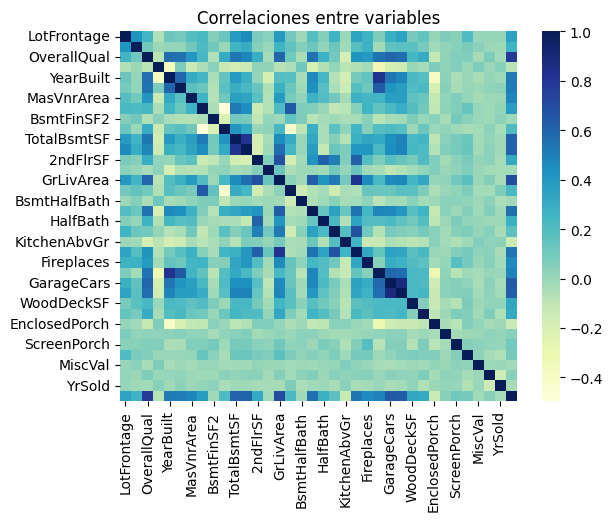

In [ ]:
dataplot = sns.heatmap(data.corr(), cmap="YlGnBu").set(title='Correlaciones entre variables')

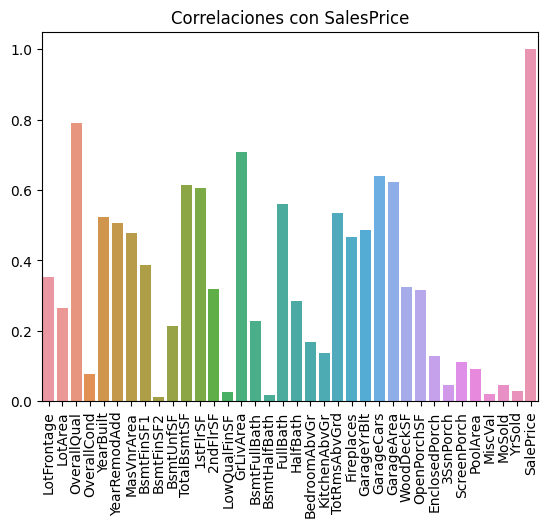

In [ ]:
sns.barplot(x=data.corr()["SalePrice"].index,y=[abs(i) for i in list(data.corr()["SalePrice"])]).set(title='Correlaciones con SalesPrice')
plt.xticks(rotation=90)
plt.show()

### Análisis de variables categóricas

### Eliminación de variables categóricas no ordinales

Antes de realizar la eliminación de las variables en relación con la correlación, hay que ver las variables que no fueron tomadas para la correlación, pues estas son variables categóricas que no sabemos si pueden ser o no ordinales.

In [ ]:
other_cols = [i for i in data.columns if i not in data.corr()["SalePrice"].index]
other_cols

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

Variables no ordinales: MSZoning, Street, LotConfig, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, Foundation, Heating, Electrical, Functional, GarageType, SaleType, SaleCondition.

Variables ordinales: LotShape, LandContour, Utilities, LandSlope, ExterQual, ExterCond, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, HeatingQC, CentralAir, KitchenQual, GarageFinish, GarageQual, GarageCond, PavedDrive.

Para este caso, descartaremos de todos los analisis las variables no ordinales.

In [ ]:
desc = 'MSZoning, Street, LotConfig, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, Foundation, Heating, Electrical, Functional, GarageType, SaleType, SaleCondition'.split(', ')
data.drop(desc, axis=1, inplace=True)
data

,LotFrontage,LotArea,LotShape,LandContour,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,65.0,8450,Reg,Lvl,AllPub,Gtl,7,5,2003,2003,...,0,61,0,0,0,0,0,2,2008,208500
1,80.0,9600,Reg,Lvl,AllPub,Gtl,6,8,1976,1976,...,298,0,0,0,0,0,0,5,2007,181500
2,68.0,11250,IR1,Lvl,AllPub,Gtl,7,5,2001,2002,...,0,42,0,0,0,0,0,9,2008,223500
3,60.0,9550,IR1,Lvl,AllPub,Gtl,7,5,1915,1970,...,0,35,272,0,0,0,0,2,2006,140000
4,84.0,14260,IR1,Lvl,AllPub,Gtl,8,5,2000,2000,...,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,62.0,7917,Reg,Lvl,AllPub,Gtl,6,5,1999,2000,...,0,40,0,0,0,0,0,8,2007,175000
1456,85.0,13175,Reg,Lvl,AllPub,Gtl,6,6,1978,1988,...,349,0,0,0,0,0,0,2,2010,210000
1457,66.0,9042,Reg,Lvl,AllPub,Gtl,7,9,1941,2006,...,0,60,0,0,0,0,2500,5,2010,266500
1458,68.0,9717,Reg,Lvl,AllPub,Gtl,5,6,1950,1996,...,366,0,112,0,0,0,0,4,2010,142125


In [ ]:
data.shape

(1460, 54)

### Eliminación de variables con alta correlación

Viendo la gráfica de correlación lineal entre la variable objetivo (SalesPrice) y las demás variables, observamos que hay varias variables con una correlación lineal sobre 0.5 por lo que esas variables serán descartadas para los splines.

In [ ]:
corrs = {data.corr()["SalePrice"].index[i]: data.corr()["SalePrice"][i] for i in range(len(data.corr()["SalePrice"].index))}
desc = [i for i in corrs if abs(corrs[i]) > 0.5]
desc.pop(-1)

'SalePrice'

In [ ]:
spldata = data.drop(desc, axis=1)
spldata

,LotFrontage,LotArea,LotShape,LandContour,Utilities,LandSlope,OverallCond,MasVnrArea,ExterQual,ExterCond,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,65.0,8450,Reg,Lvl,AllPub,Gtl,5,196.0,Gd,TA,...,0,61,0,0,0,0,0,2,2008,208500
1,80.0,9600,Reg,Lvl,AllPub,Gtl,8,0.0,TA,TA,...,298,0,0,0,0,0,0,5,2007,181500
2,68.0,11250,IR1,Lvl,AllPub,Gtl,5,162.0,Gd,TA,...,0,42,0,0,0,0,0,9,2008,223500
3,60.0,9550,IR1,Lvl,AllPub,Gtl,5,0.0,TA,TA,...,0,35,272,0,0,0,0,2,2006,140000
4,84.0,14260,IR1,Lvl,AllPub,Gtl,5,350.0,Gd,TA,...,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,62.0,7917,Reg,Lvl,AllPub,Gtl,5,0.0,TA,TA,...,0,40,0,0,0,0,0,8,2007,175000
1456,85.0,13175,Reg,Lvl,AllPub,Gtl,6,119.0,TA,TA,...,349,0,0,0,0,0,0,2,2010,210000
1457,66.0,9042,Reg,Lvl,AllPub,Gtl,9,0.0,Ex,Gd,...,0,60,0,0,0,0,2500,5,2010,266500
1458,68.0,9717,Reg,Lvl,AllPub,Gtl,6,0.0,TA,TA,...,366,0,112,0,0,0,0,4,2010,142125


### Eliminación de variables desbalanceadas

Por otro lado, eliminaremos las variables que tengan pocas categorías o que estén extremandamente desbalanceadas, estas son LandContour, Utilities, LandSlope, ExterCond, BsmtCond, BsmtFinType2, BsmtFinSF2, CentralAir, LowQualFinSF, BsmtHalfBath, KitchenAbvGr, GarageQual, GarageCond, PavedDrive, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea y MiscVal.

In [ ]:
spldata.shape

(1460, 44)

In [ ]:
desc = 'LandContour, Utilities, LandSlope, ExterCond, BsmtCond, BsmtFinType2, BsmtFinSF2, CentralAir, LowQualFinSF, BsmtHalfBath, KitchenAbvGr, GarageQual, GarageCond, PavedDrive, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal'.split(', ')
spldata.drop(desc, axis=1, inplace=True)
data.drop(desc, axis=1, inplace=True)
spldata

,LotFrontage,LotArea,LotShape,OverallCond,MasVnrArea,ExterQual,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,...,BedroomAbvGr,KitchenQual,Fireplaces,GarageYrBlt,GarageFinish,WoodDeckSF,OpenPorchSF,MoSold,YrSold,SalePrice
0,65.0,8450,Reg,5,196.0,Gd,Gd,No,GLQ,706,...,3,Gd,0,2003.0,RFn,0,61,2,2008,208500
1,80.0,9600,Reg,8,0.0,TA,Gd,Gd,ALQ,978,...,3,TA,1,1976.0,RFn,298,0,5,2007,181500
2,68.0,11250,IR1,5,162.0,Gd,Gd,Mn,GLQ,486,...,3,Gd,1,2001.0,RFn,0,42,9,2008,223500
3,60.0,9550,IR1,5,0.0,TA,TA,No,ALQ,216,...,3,Gd,1,1998.0,Unf,0,35,2,2006,140000
4,84.0,14260,IR1,5,350.0,Gd,Gd,Av,GLQ,655,...,4,Gd,1,2000.0,RFn,192,84,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,62.0,7917,Reg,5,0.0,TA,Gd,No,Unf,0,...,3,TA,1,1999.0,RFn,0,40,8,2007,175000
1456,85.0,13175,Reg,6,119.0,TA,Gd,No,ALQ,790,...,3,TA,2,1978.0,Unf,349,0,2,2010,210000
1457,66.0,9042,Reg,9,0.0,Ex,TA,No,GLQ,275,...,4,Gd,2,1941.0,RFn,0,60,5,2010,266500
1458,68.0,9717,Reg,6,0.0,TA,TA,Mn,GLQ,49,...,2,Gd,0,1950.0,Unf,366,0,4,2010,142125


In [ ]:
spldata.shape

(1460, 25)

Esto nos deja con 24 variables a considerar para realizar los splines, aquí podemos ver que hay una variable específica para el mes de la venta y otra para el año, por lo cual estas dos se pueden combinar en una sola variable que es la fecha de venta.

In [ ]:
data['DateSold'] = pd.to_datetime(dict(year=data.YrSold, month=data.MoSold, day = 1))
spldata['DateSold'] = pd.to_datetime(dict(year=data.YrSold, month=data.MoSold, day = 1))
data.drop(['YrSold', 'MoSold'], axis=1, inplace=True)
spldata.drop(['YrSold', 'MoSold'], axis=1, inplace=True)
spldata

,LotFrontage,LotArea,LotShape,OverallCond,MasVnrArea,ExterQual,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,...,HalfBath,BedroomAbvGr,KitchenQual,Fireplaces,GarageYrBlt,GarageFinish,WoodDeckSF,OpenPorchSF,SalePrice,DateSold
0,65.0,8450,Reg,5,196.0,Gd,Gd,No,GLQ,706,...,1,3,Gd,0,2003.0,RFn,0,61,208500,2008-02-01
1,80.0,9600,Reg,8,0.0,TA,Gd,Gd,ALQ,978,...,0,3,TA,1,1976.0,RFn,298,0,181500,2007-05-01
2,68.0,11250,IR1,5,162.0,Gd,Gd,Mn,GLQ,486,...,1,3,Gd,1,2001.0,RFn,0,42,223500,2008-09-01
3,60.0,9550,IR1,5,0.0,TA,TA,No,ALQ,216,...,0,3,Gd,1,1998.0,Unf,0,35,140000,2006-02-01
4,84.0,14260,IR1,5,350.0,Gd,Gd,Av,GLQ,655,...,1,4,Gd,1,2000.0,RFn,192,84,250000,2008-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,62.0,7917,Reg,5,0.0,TA,Gd,No,Unf,0,...,1,3,TA,1,1999.0,RFn,0,40,175000,2007-08-01
1456,85.0,13175,Reg,6,119.0,TA,Gd,No,ALQ,790,...,0,3,TA,2,1978.0,Unf,349,0,210000,2010-02-01
1457,66.0,9042,Reg,9,0.0,Ex,TA,No,GLQ,275,...,0,4,Gd,2,1941.0,RFn,0,60,266500,2010-05-01
1458,68.0,9717,Reg,6,0.0,TA,TA,Mn,GLQ,49,...,0,2,Gd,0,1950.0,Unf,366,0,142125,2010-04-01


De esta forma, nos quedamos con 23 variables predictoras con las que potencialmente se pueden realizar splines

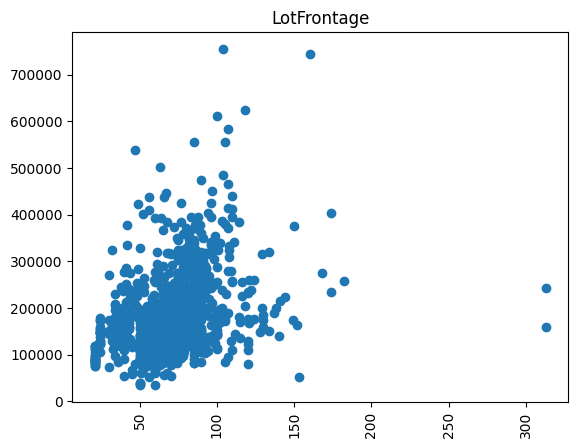

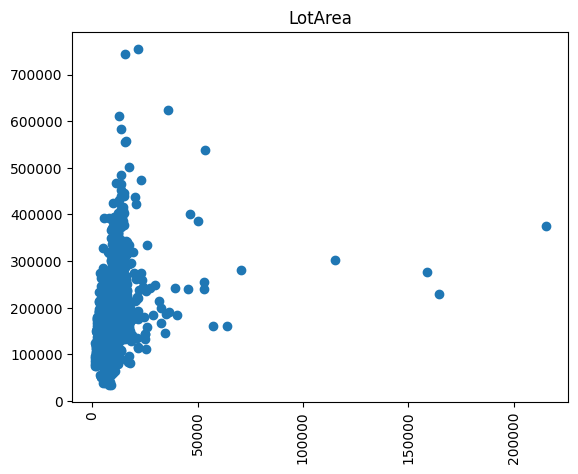

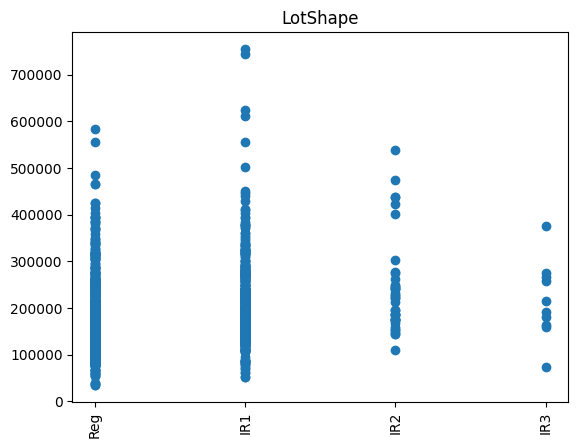

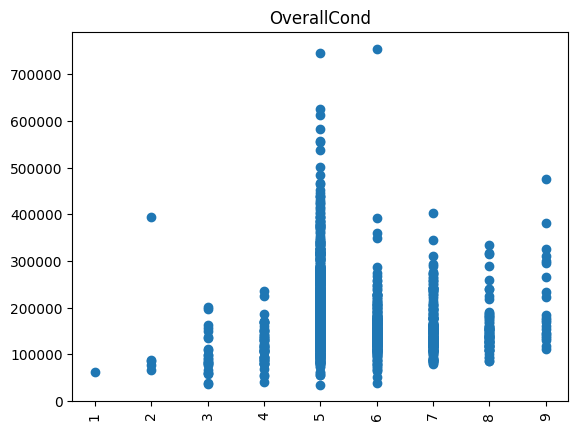

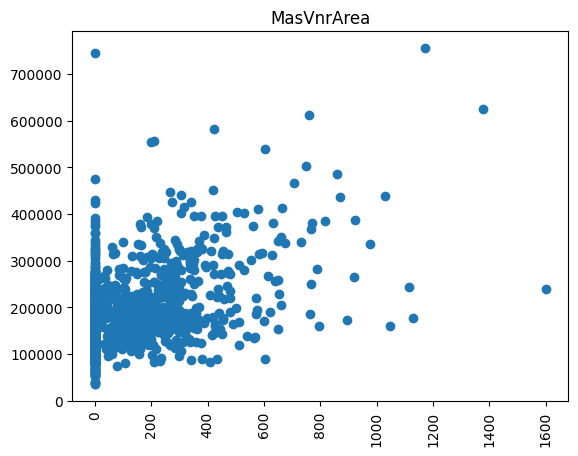

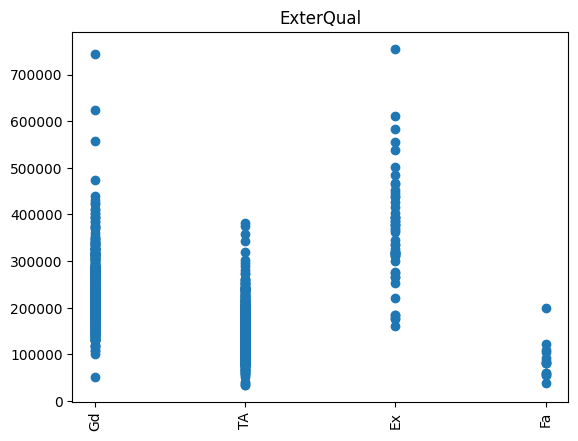

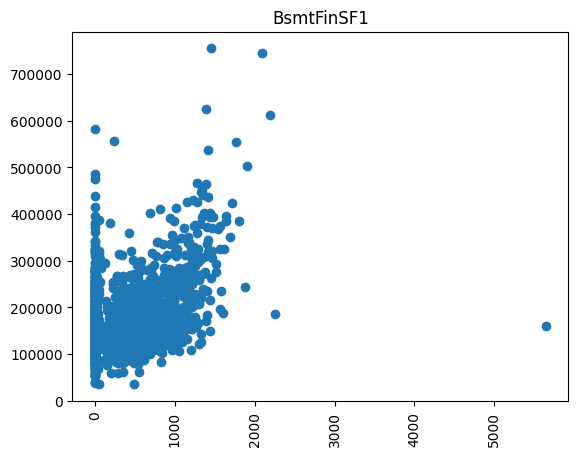

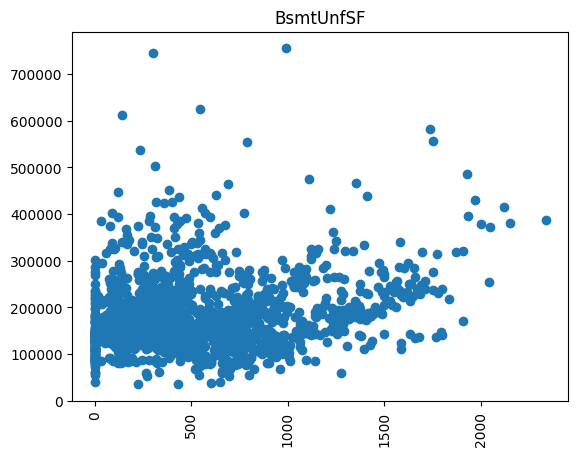

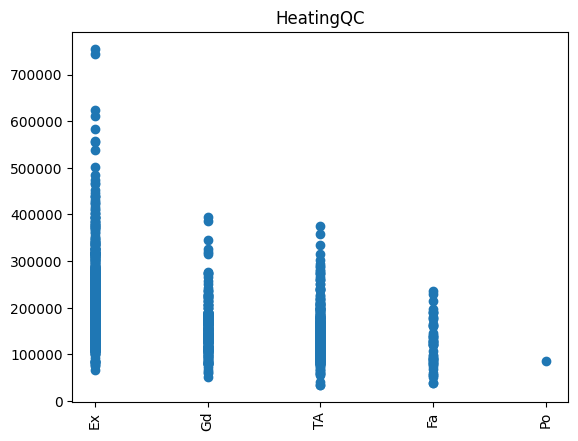

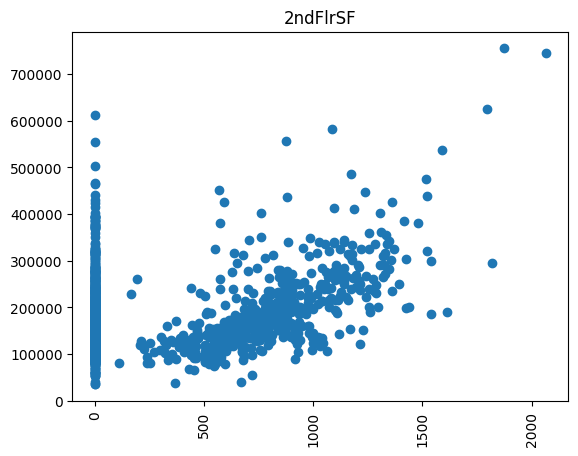

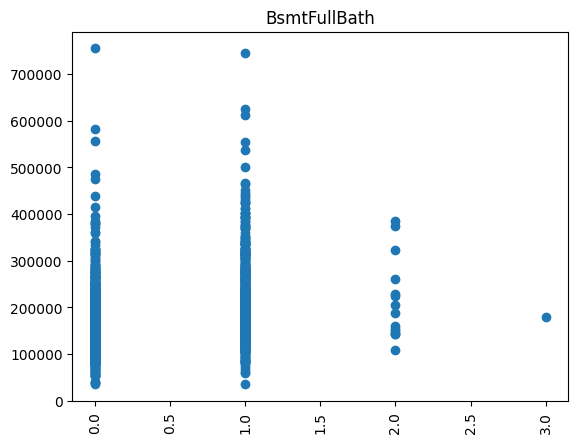

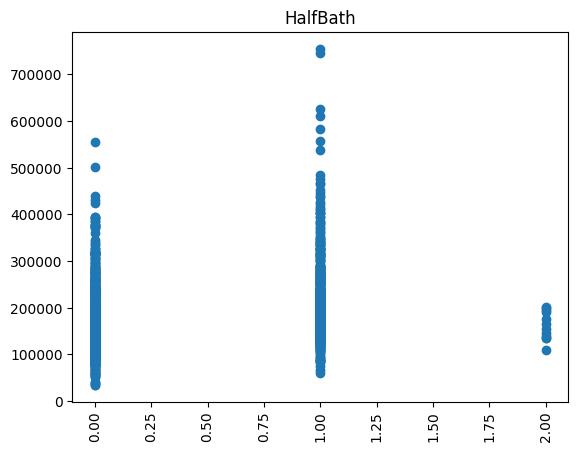

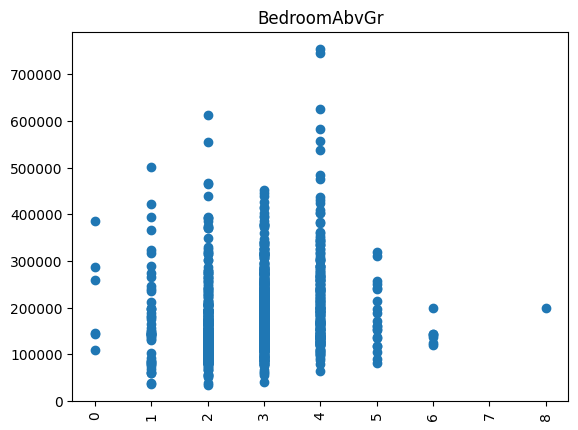

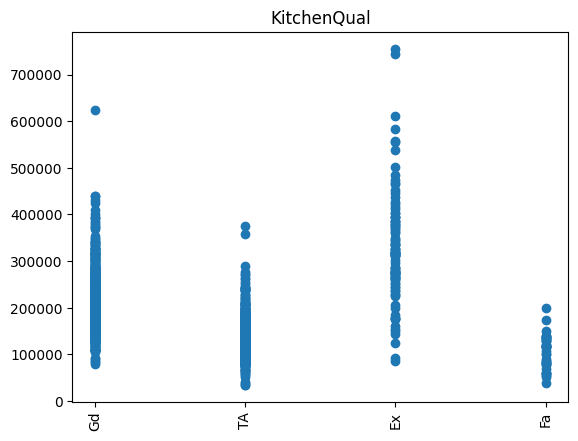

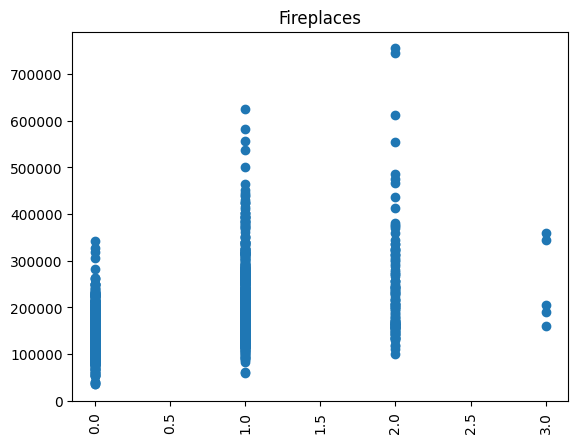

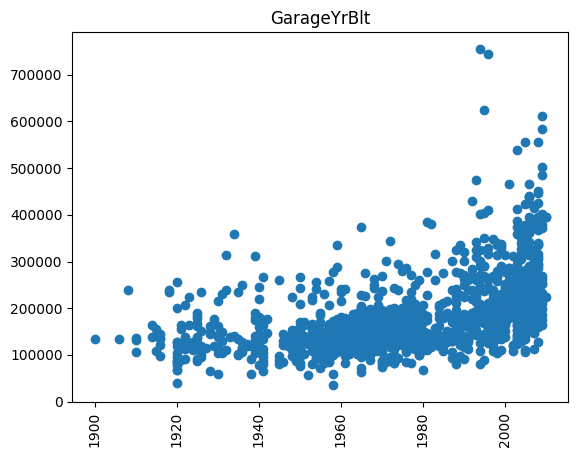

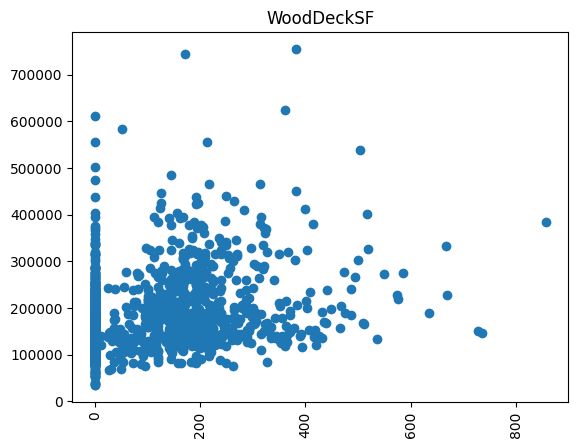

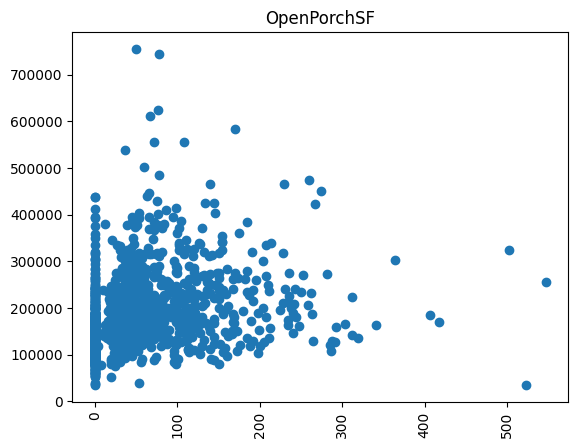

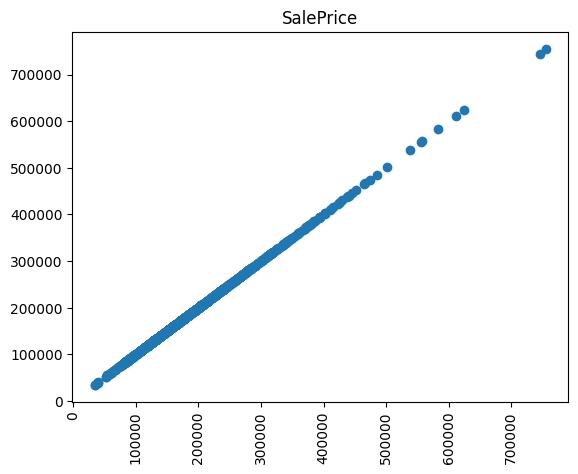

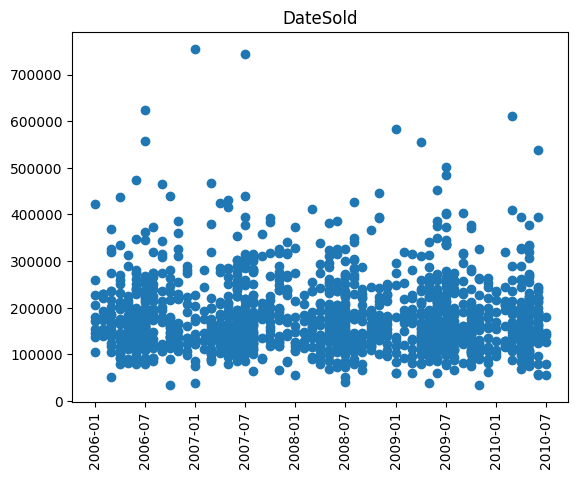

In [ ]:
for i in spldata.columns:
    try:
        plt.scatter(spldata[i], spldata['SalePrice'])
        plt.title(i)
        plt.xticks(rotation=90)
        plt.show()
    except:
        pass

### Pruebas de no linealidad

Aplicaremos alguna prueba de linealidad para determinar cuales de estas variables no tienen una relación lineal con la variable de precio.

Para ver esto, aplicaremos un test de BreuschPagan la cual toma como hipótesis nula la homocedasticidad de los datos, en caso de rechazar dicha hipótesis, tendremos que los datos no tienen una relación lineal y los podremos usar para realizar los splines.

In [ ]:
spldata2 = data.copy()
spldata.rename(columns={'2ndFlrSF': 'FlrSF2nd'}, inplace=True)
cols = []
for c in spldata.columns:
    if c != 'SalePrice':
        fit = smf.ols(f'SalePrice ~ {c}', data = spldata).fit()
        test = sms.het_breuschpagan (fit.resid, fit.model.exog)
        print(c)
        print(f'Valor-p: {test[1]}')
        if test[1] > 0.05:
            cols.append(c)

print(f'Las variables que tuvieron un p-valor superior a 0.05 fueron: {cols}')
cols.append('SalePrice')

LotFrontage
Valor-p: 3.518611240829579e-18
LotArea
Valor-p: 6.835033748430927e-16
LotShape
Valor-p: 0.029877622277181257
OverallCond
Valor-p: 0.0010741786185357834
MasVnrArea
Valor-p: 5.857874587170551e-19
ExterQual
Valor-p: 1.1199778864498732e-15
BsmtQual
Valor-p: 7.277349194434461e-25
BsmtExposure
Valor-p: 1.200907869209988e-13
BsmtFinType1
Valor-p: 7.927868113184342e-08
BsmtFinSF1
Valor-p: 7.540845331258169e-16
BsmtUnfSF
Valor-p: 0.17717343160496224
HeatingQC
Valor-p: 2.874058864202026e-08
FlrSF2nd
Valor-p: 0.0007516771938391848
BsmtFullBath
Valor-p: 0.0007916086338890352
HalfBath
Valor-p: 0.00024802962915634186
BedroomAbvGr
Valor-p: 0.23578222079083405
KitchenQual
Valor-p: 1.387662049080963e-30
Fireplaces
Valor-p: 2.1448881463113303e-19
GarageYrBlt
Valor-p: 6.608379685225846e-06
GarageFinish
Valor-p: 1.4054367117496767e-12
WoodDeckSF
Valor-p: 4.804723824606456e-07
OpenPorchSF
Valor-p: 4.355422730669087e-09
DateSold
Valor-p: 0.265671807877526
Las variables que tuvieron un p-valor su

Así, tras realizar la prueba de BreuschPagan, nos quedan 3 posibles variables para realizar los splines:

In [ ]:
spldata = spldata[cols]
spldata

,BsmtUnfSF,BedroomAbvGr,DateSold,SalePrice
0,150,3,2008-02-01,208500
1,284,3,2007-05-01,181500
2,434,3,2008-09-01,223500
3,540,3,2006-02-01,140000
4,490,4,2008-12-01,250000
...,...,...,...,...
1455,953,3,2007-08-01,175000
1456,589,3,2010-02-01,210000
1457,877,4,2010-05-01,266500
1458,0,2,2010-04-01,142125


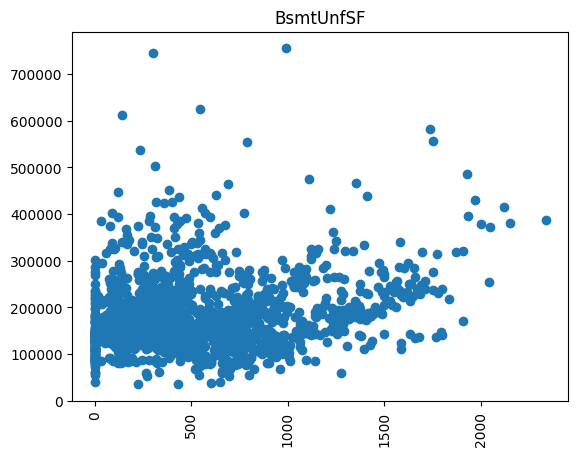

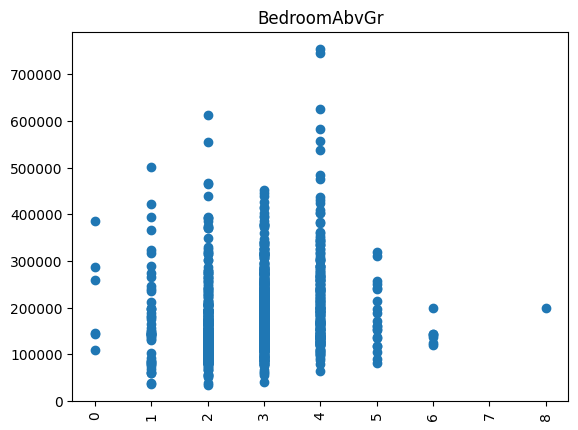

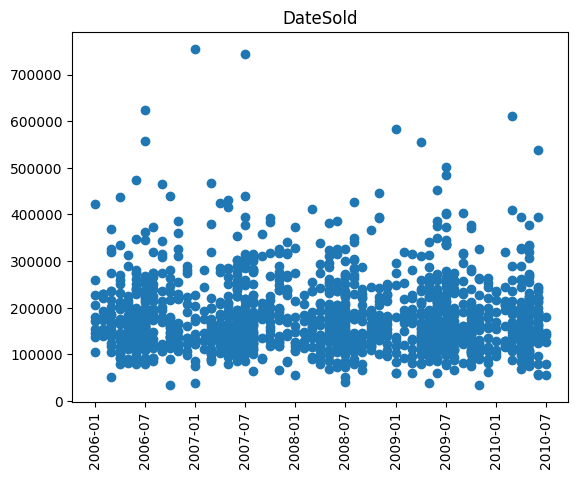

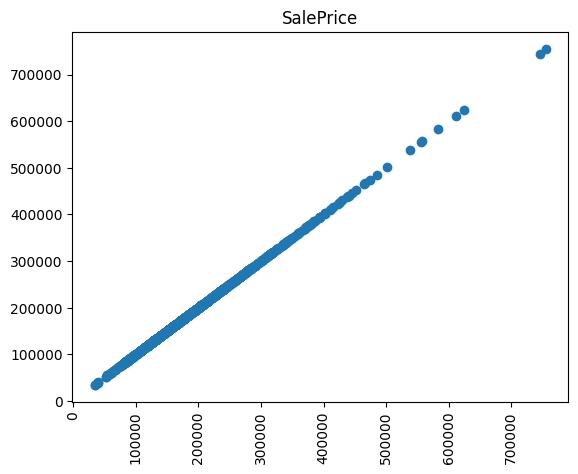

In [ ]:
for i in spldata.columns:
    plt.scatter(spldata[i], spldata['SalePrice'])
    plt.title(i)
    plt.xticks(rotation=90)
    plt.show()

Las 3 variables que tenemos como opción son BsmtUnfSF que representa el área sin terminar del sótano, BedroomAbvGr que es la cantidad de habitaciónes que están sobre el piso y DateSold, que es la variable que creamos uniendo mes y año de venta. Dado que la variable DateSold es una fecha, esta se debe serializar según el día para que se interprete como numérica y poder pasarla a los splines.

In [ ]:
from datetime import datetime
def serialize(date):
    temp = datetime(2006, 1, 1)
    delta = date - temp
    return float(delta.days)

In [ ]:
spldata['DateSold'] = spldata['DateSold'].apply(serialize)

/tmp/ipykernel_365/509375660.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spldata['DateSold'] = spldata['DateSold'].apply(serialize)


In [ ]:
spldata

,BsmtUnfSF,BedroomAbvGr,DateSold,SalePrice
0,150,3,761.0,208500
1,284,3,485.0,181500
2,434,3,974.0,223500
3,540,3,31.0,140000
4,490,4,1065.0,250000
...,...,...,...,...
1455,953,3,577.0,175000
1456,589,3,1492.0,210000
1457,877,4,1581.0,266500
1458,0,2,1551.0,142125


## Busqueda del mejor modelo

En este caso, dada la naturaleza continua de la variable BsmtUnfSF, pensamos que el mejor resultado se obtendría con los splines aplicados a esta variable, por lo que el modelo será realizado con esta. Para todas las pruebas utilizaremos validación cruzada, tomando una muestra al azar y entrenando el modelo 100 veces.

In [ ]:
X = spldata['BsmtUnfSF']
y = spldata['SalePrice']



X, X_test, y, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

En primera instancia, optaremos por realizar splines, tanto cúbicos como naturales variando la cantidad de nodos entre 3 y 10, pero sin elegir a mano cuáles serán esos nodos.

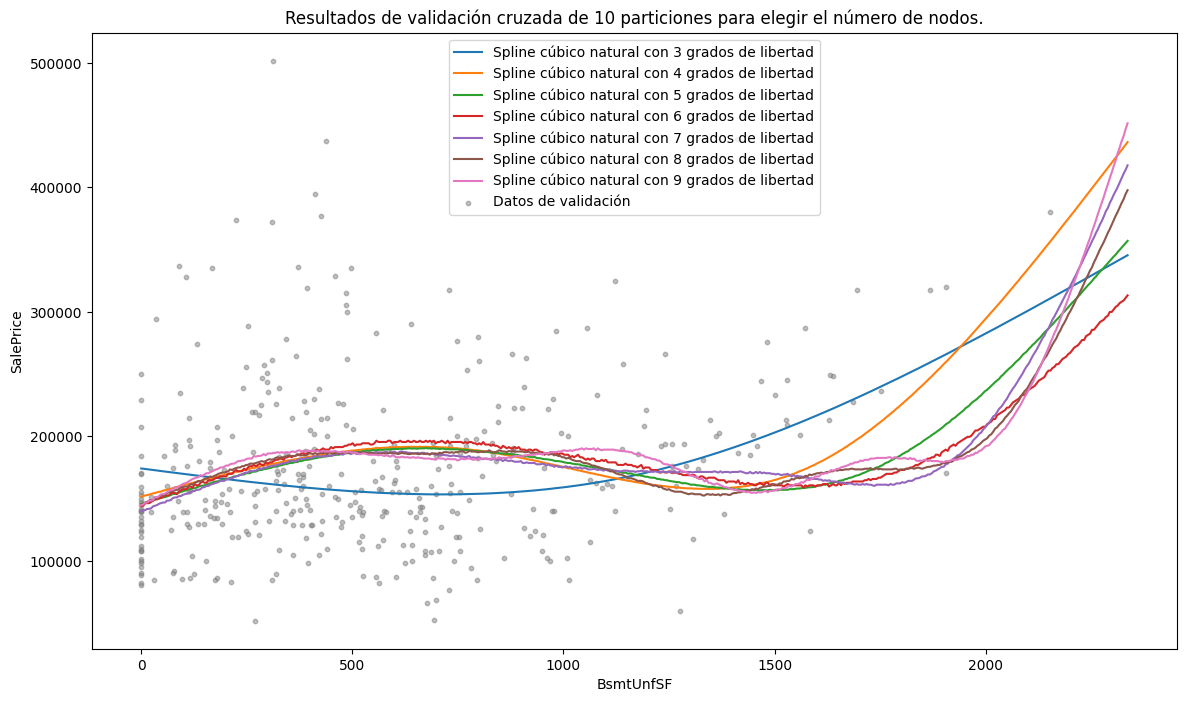

Para 3 grados de libertad se tiene un mse promedio de 75143.06220001922, con una varianza de 22395794.970949374
Para 4 grados de libertad se tiene un mse promedio de 73161.41076208954, con una varianza de 18534812.632932007
Para 5 grados de libertad se tiene un mse promedio de 73613.13211136177, con una varianza de 18624576.394850247
Para 6 grados de libertad se tiene un mse promedio de 74056.04236537097, con una varianza de 18652310.77562996
Para 7 grados de libertad se tiene un mse promedio de 74283.87518047869, con una varianza de 17926685.426711187
Para 8 grados de libertad se tiene un mse promedio de 74689.95195236967, con una varianza de 21726661.947656814
Para 9 grados de libertad se tiene un mse promedio de 74482.80478664784, con una varianza de 27205690.91684865


In [ ]:
X_plot = np.linspace(min(X), max(X), 500).reshape(-1, 1)

plt.figure(figsize=(14, 8))


natural_spline_mse_es = {}

for df in range(3,10):
    for i in range(100):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)
        X_spline_train_natural = dmatrix(f"cr(data, df={df})",
                                        {"data": X_train.ravel()}, return_type='dataframe')

        model_spline_natural = LinearRegression()
        model_spline_natural.fit(X_spline_train_natural, y_train)

        X_spline_val_natural = dmatrix(f"cr(data, df={df})",
                                    {"data": X_val.ravel()}, return_type='dataframe')
        y_spline_val_pred_natural = model_spline_natural.predict(X_spline_val_natural)
        rmse_val_natural = np.sqrt(mean_squared_error(y_val, y_spline_val_pred_natural))

        if i == 0:
            natural_spline_mse_es[df] = [rmse_val_natural]
        else:
            natural_spline_mse_es[df].append(rmse_val_natural)
    X_spline_plot_natural = dmatrix(f"cr(data, df={df})",
                                        {"data": X_plot.ravel()}, return_type='dataframe')
    y_spline_plot_natural = model_spline_natural.predict(X_spline_plot_natural)
    plt.plot(X_plot, y_spline_plot_natural, label=f"Spline cúbico natural con {df} grados de libertad")
plt.scatter(X_val, y_val, s=10, color='gray', alpha=0.5, label="Datos de validación")

plt.title('Resultados de validación cruzada de 10 particiones para elegir el número de nodos.')
plt.xlabel('BsmtUnfSF')
plt.ylabel('SalePrice')
plt.legend()
plt.show()

for i in natural_spline_mse_es.keys():
    print(f'Para {i} grados de libertad se tiene un mse promedio de {np.mean(natural_spline_mse_es[i])}, con una varianza de {np.var(natural_spline_mse_es[i])}')

Para los splines naturales, el número de nodos que tiene una mejor relación entre error y varianza es 6, con un error y varianza bajos por lo que probaremos a elegir 6 nodos a mano para intentar mejorar ese resultado. Aquí hay que notar que por defecto, el método definido en scipy toma 2 nodos extra: el inicio y el final de los datos, por lo que realizaremos pruebas con 4 nodos sin incluir los extremos.

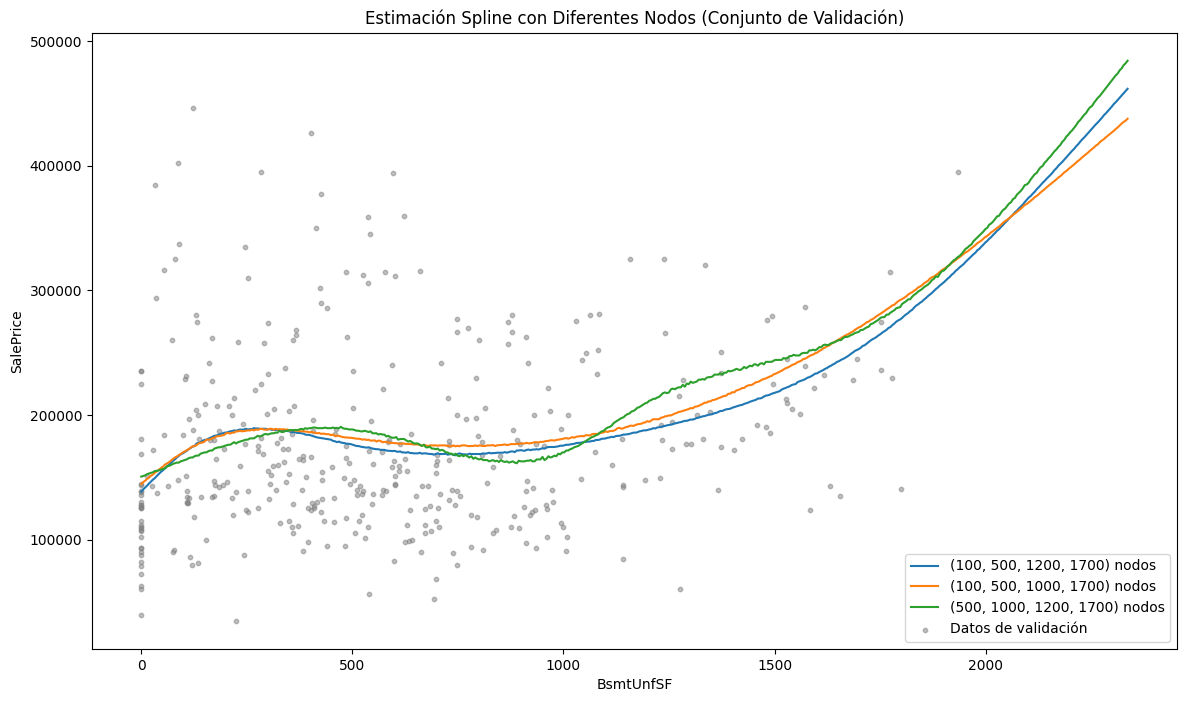

Para los nodos (100, 500, 1200, 1700) se tiene un mse promedio de 73320.4307193763, con una varianza de 13886461.140316807
Para los nodos (100, 500, 1000, 1700) se tiene un mse promedio de 74854.28607460624, con una varianza de 48812116.60330576
Para los nodos (500, 1000, 1200, 1700) se tiene un mse promedio de 73797.65696601379, con una varianza de 17496742.284347948


In [ ]:
knots_list = [(100, 500, 1200, 1700),
              (100, 500, 1000, 1700),
              (500, 1000, 1200, 1700)]

spline_models = {}
spline_mse = {}

plt.figure(figsize=(14, 8))



for idx, knots in enumerate(knots_list):
    for i in range(100):
        # Número de nodos
        num_nodes = len(knots) + 2
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

        # Matriz de diseño
        X_spline_train = dmatrix(f"cr(data, knots={knots})", {"data": X_train.ravel()}, return_type='dataframe')
        X_spline_val = dmatrix(f"cr(data, knots={knots})", {"data": X_val.ravel()}, return_type='dataframe')


        # Ajustamos el modelo de regresión lineal
        model_spline = LinearRegression()
        model_spline.fit(X_spline_train, y_train)

        spline_models[knots] = model_spline

        y_spline_val_pred = model_spline.predict(X_spline_val)
        rmse_val = np.sqrt(mean_squared_error(y_val, y_spline_val_pred))
        if i == 0:
            spline_mse[knots] = [rmse_val]
        else:
            spline_mse[knots].append(rmse_val)

    # Graficamos el modelo
    X_spline_plot = dmatrix(f"cr(data, knots={knots})",
                        {"data": X_plot.ravel()}, return_type='dataframe')

    y_spline_plot = model_spline.predict(X_spline_plot)
    plt.plot(X_plot, y_spline_plot, label=f"{knots} nodos")

plt.scatter(X_val, y_val, s=10, color='gray', alpha=0.5, label="Datos de validación")
# Etiquetas y título
plt.xlabel('BsmtUnfSF')
plt.ylabel('SalePrice')
plt.title("Estimación Spline con Diferentes Nodos (Conjunto de Validación)")
plt.legend()
plt.show()

# Mostramos el MSE de validación para cada modelo spline
spline_mse
for i in spline_mse.keys():
    print(f'Para los nodos {i} se tiene un mse promedio de {np.mean(spline_mse[i])}, con una varianza de {np.var(spline_mse[i])}')


En este caso, al elegir los 4 nodos a mano se logró mejorar ligeramente el desempeño, reduciendo un poco el error y manteniendo la varianza en el mismo rango de valores

97059.04057236898


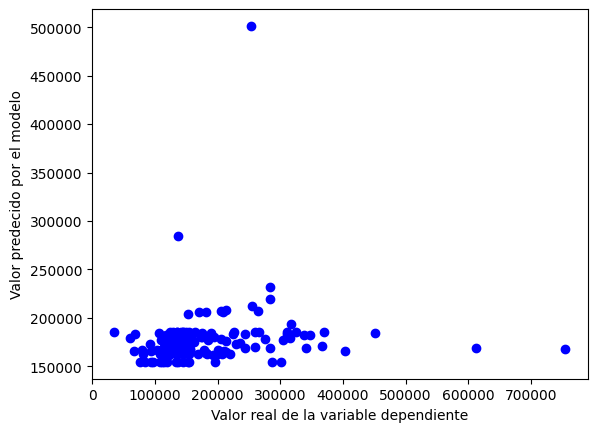

In [ ]:
knots = (500, 1000, 1200, 1700)
X_spline = dmatrix(f"cr(data, knots={knots})", {"data": X.ravel()}, return_type='dataframe')
model_spline = LinearRegression()
model_spline.fit(X_spline, y)

X_spline_test = dmatrix(f"cr(data, knots={knots})", {"data": X_test.ravel()}, return_type='dataframe')
y_spline_test_pred = model_spline.predict(X_spline_test)
rmse = np.sqrt(mean_squared_error(y_test, y_spline_test_pred))
plt.scatter(y_test, y_spline_test_pred, color="blue")
plt.xlabel('Valor real de la variable dependiente')
plt.ylabel('Valor predecido por el modelo')
print(rmse)

Sin embargo, al realizar el modelo con todos los datos de entrenamiento y validarlo contra el conjunto de testeo, podemos ver que no logra capturar correctamente la tendencia de los datos.

Ahora realizaremos la misma prueba para splines cúbicos

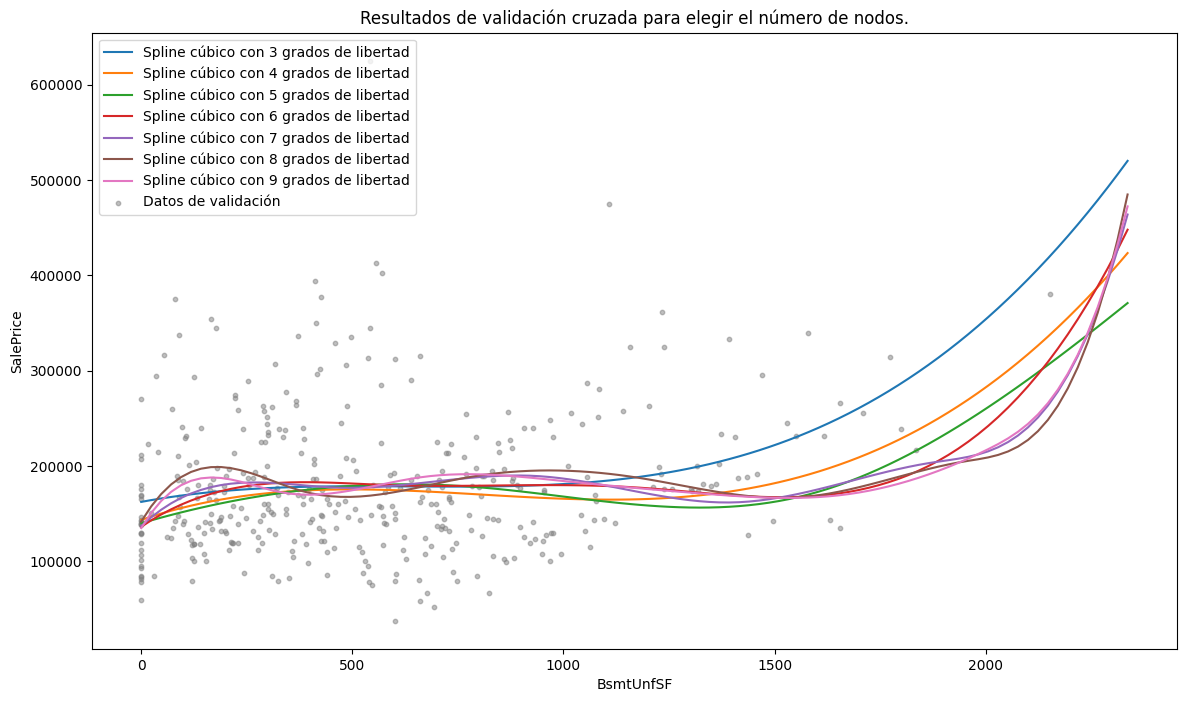

Para 3 grados de libertad se tiene un mse promedio de 74951.35693969387, con una varianza de 20873068.58785113
Para 4 grados de libertad se tiene un mse promedio de 74202.99019138287, con una varianza de 17285428.47017462
Para 5 grados de libertad se tiene un mse promedio de 74140.8865443727, con una varianza de 19919805.810853772
Para 6 grados de libertad se tiene un mse promedio de 74269.822598893, con una varianza de 16011083.487000635
Para 7 grados de libertad se tiene un mse promedio de 74088.72797715646, con una varianza de 20278255.284916542
Para 8 grados de libertad se tiene un mse promedio de 74046.98829174331, con una varianza de 17830893.07375739
Para 9 grados de libertad se tiene un mse promedio de 73204.09498986855, con una varianza de 16906472.723229147


In [ ]:
X_plot = np.linspace(min(X_train), max(X_train), 100).reshape(-1, 1)

plt.figure(figsize=(14, 8))
natural_spline_mse_es = {}

for df in range(3,10):
    for i in range(100):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)
        X_spline_train_natural = dmatrix(f"bs(data, df = {df}, include_intercept=False)",
                                        {"data": X_train.ravel()}, return_type='dataframe')

        model_spline_natural = LinearRegression()
        model_spline_natural.fit(X_spline_train_natural, y_train)

        X_spline_val_natural = dmatrix(f"bs(data, df = {df}, include_intercept=False)",
                                    {"data": X_val.ravel()}, return_type='dataframe')
        y_spline_val_pred_natural = model_spline_natural.predict(X_spline_val_natural)
        rmse_val_natural = np.sqrt(mean_squared_error(y_val, y_spline_val_pred_natural))

        if i == 0:
            natural_spline_mse_es[df] = [rmse_val_natural]
        else:
            natural_spline_mse_es[df].append(rmse_val_natural)
    X_spline_plot_natural = dmatrix(f"bs(data, df = {df}, include_intercept=False)",
                                        {"data": X_plot.ravel()}, return_type='dataframe')
    y_spline_plot_natural = model_spline_natural.predict(X_spline_plot_natural)
    plt.plot(X_plot, y_spline_plot_natural, label=f"Spline cúbico con {df} grados de libertad")

plt.scatter(X_val, y_val, s=10, color='gray', alpha=0.5, label="Datos de validación")
plt.title('Resultados de validación cruzada para elegir el número de nodos.')
plt.xlabel('BsmtUnfSF')
plt.ylabel('SalePrice')
plt.legend()
plt.show()

for i in natural_spline_mse_es.keys():
    print(f'Para {i} grados de libertad se tiene un mse promedio de {np.mean(natural_spline_mse_es[i])}, con una varianza de {np.var(natural_spline_mse_es[i])}')

En este caso, podemos observar que los splines cúbicos con 5 nodos obtuvieron los mejores resultados, con una varianza pequeña en comparación a los demás números y con un error que aunque no es el menor, es bajo. Por esto, al igual que antes, pasaremos a escoger a mano un par de opciones para el lugar de los nodos, intentando mejorar este resultado.

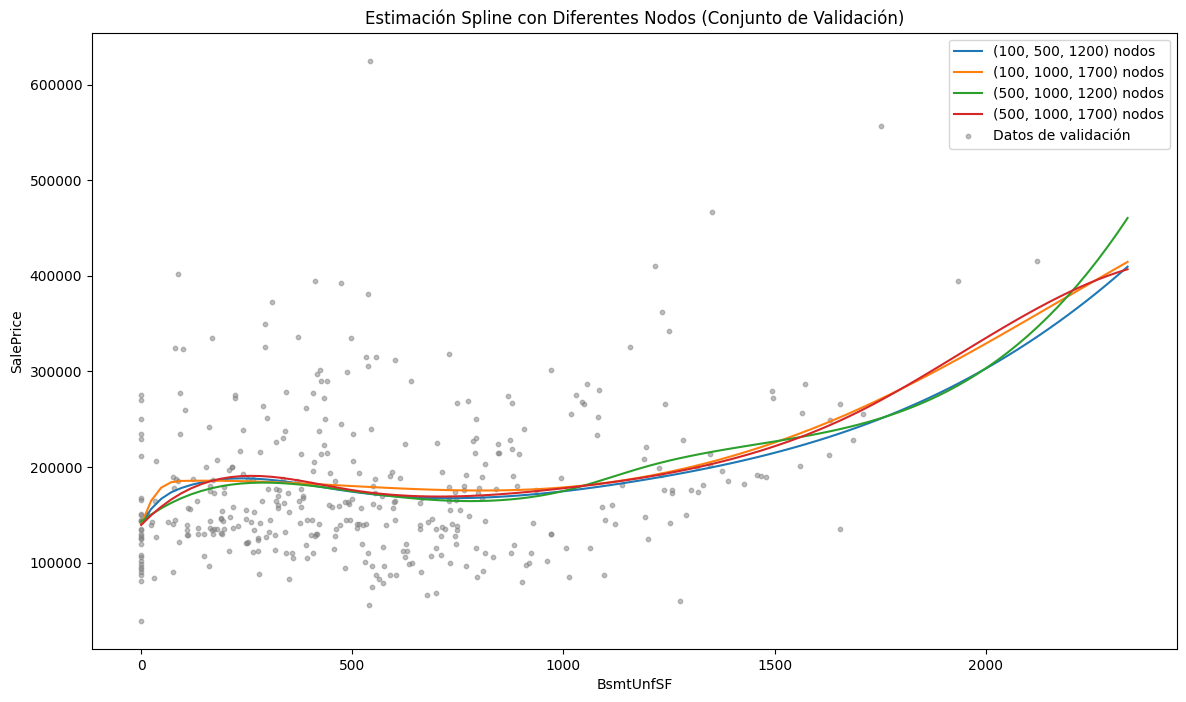

Para los nodos (100, 500, 1200) se tiene un mse promedio de 73887.86775091472, con una varianza de 18274677.65216005
Para los nodos (100, 1000, 1700) se tiene un mse promedio de 73832.7779301703, con una varianza de 20753269.075485293
Para los nodos (500, 1000, 1200) se tiene un mse promedio de 74175.33112878965, con una varianza de 18857316.411678396
Para los nodos (500, 1000, 1700) se tiene un mse promedio de 74235.59275624334, con una varianza de 19989742.83910104


In [ ]:
knots_list = [(100, 500, 1200),
              (100, 1000, 1700),
              (500, 1000,1200),
              (500, 1000, 1700)]

spline_models = {}
spline_mse = {}

plt.figure(figsize=(14, 8))



for idx, knots in enumerate(knots_list):
    for i in range(100):
        # Número de nodos
        num_nodes = len(knots) + 2
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

        # Matriz de diseño
        X_spline_train = dmatrix(f"bs(data, knots={knots})", {"data": X_train.ravel()}, return_type='dataframe')
        X_spline_val = dmatrix(f"bs(data, knots={knots})", {"data": X_val.ravel()}, return_type='dataframe')


        # Ajustamos el modelo de regresión lineal
        model_spline = LinearRegression()
        model_spline.fit(X_spline_train, y_train)

        spline_models[knots] = model_spline

        y_spline_val_pred = model_spline.predict(X_spline_val)
        rmse_val = np.sqrt(mean_squared_error(y_val, y_spline_val_pred))
        if i == 0:
            spline_mse[knots] = [rmse_val]
        else:
            spline_mse[knots].append(rmse_val)

    # Graficamos el modelo
    X_spline_plot = dmatrix(f"bs(data, knots={knots})",
                        {"data": X_plot.ravel()}, return_type='dataframe')

    y_spline_plot = model_spline.predict(X_spline_plot)
    plt.plot(X_plot, y_spline_plot, label=f"{knots} nodos")

plt.scatter(X_val, y_val, s=10, color='gray', alpha=0.5, label="Datos de validación")
# Etiquetas y título
plt.xlabel('BsmtUnfSF')
plt.ylabel('SalePrice')
plt.title("Estimación Spline con Diferentes Nodos (Conjunto de Validación)")
plt.legend()
plt.show()

# Mostramos el MSE de validación para cada modelo spline
spline_mse
for i in spline_mse.keys():
    print(f'Para los nodos {i} se tiene un mse promedio de {np.mean(spline_mse[i])}, con una varianza de {np.var(spline_mse[i])}')


En este caso, podemos observar que la elección de nodos que minimiza el error es (500, 1000, 1700), aunque tiene una varianza muy alta en comparación a los resultados previos, veamos cómo se desempeña el modelo con estos nodos sobre el conjunto de testeo.

In [ ]:
X_test

892      396
1105     431
413     1008
522      605
1036     598
        ... 
526      551
101      741
1092     758
411        0
1392      95
Name: BsmtUnfSF, Length: 146, dtype: int64

## Evaluación con los datos independientes

96697.1303826852


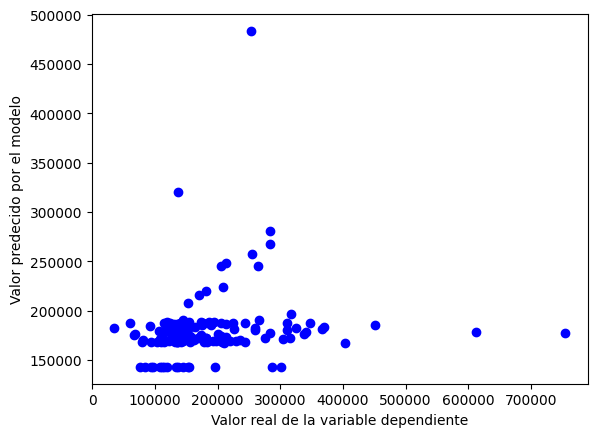

In [ ]:
knots = (500, 1000, 1200)
X_spline = dmatrix(f"bs(data, knots={knots})", {"data": X.ravel()}, return_type='dataframe')
model_spline = LinearRegression()
model_spline.fit(X_spline, y)

X_spline_test = dmatrix(f"bs(data, knots={knots})", {"data": X_test.ravel()}, return_type='dataframe')
y_spline_test_pred = model_spline.predict(X_spline_test)
rmse = np.sqrt(mean_squared_error(y_test, y_spline_test_pred))
plt.scatter(y_test, y_spline_test_pred, color="blue")
plt.xlabel('Valor real de la variable dependiente')
plt.ylabel('Valor predecido por el modelo')
print(rmse)

En este caso, tuvo un RMSE mejor que el modelo de splines naturales que se entrenó previamente.

Tras realizar el proceso de selección de variables y de realizar distintos modelos de splines sobre esta variable, llegamos a la conclusión de que el mejor desempeño en este problema lo obtienen los splines cúbicos con 5 nodos, sin embargo, cabe destacar que el desempeño de este tipo de modelo para este problema en particular resulta ser muy bajo, por lo que es aconsejable buscar otras opciones.

De esta forma, el modelo entregado será un modelo de splines cúbicos utilizando la variable BsmtUnfSF con 5 nodos ubicados en el inicio, 500, 1000, 1200 y el final.

# Sección Kernel

Para este ejercicio utilizaremos un dataset de House Prices, en el cual se compilan 79 variables predictoras para el precio de una casa en venta. Realizaremos estimaciones del precio de las casas mediante splines y mediante métodos de kernel. El notebook está dividido en 3 partes: una exploración inicial de los datos, la implementación del suavizado con kernel y una comparación de resultados y conclusiones.

In [ ]:
data_kernel.shape

(1460, 81)

## Exploración de los datos

Para la exploración de datos se procederá de una forma similar al notebook en el que se implementaron los splines, eliminando primero variables con pocos registros y posteriormente se realizará un análisis sobre las demás variables para determinar cuales utilizar para el suavizado.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


In [ ]:
data = data_kernel.copy()

In [ ]:
data.shape

(1460, 81)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [ ]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
data_kernel.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


En este caso, se eliminarán Id, PoolQC, Fence, MiscFeature, FireplaceQu y Alley

In [ ]:
data.drop(['Id','PoolQC', 'Fence', 'MiscFeature', 'FireplaceQu', 'Alley'], axis=1, inplace=True)

### Variables numéricas

Para las variables numéricas consideraremos aquellas que tengan más de 30 valores distintos y haremos el análisis sobre ellas

In [ ]:
data.rename(columns={'3SsnPorch': 'SsnPorch'}, inplace=True)
numerical_cols = []
for c in data.columns:
    n_unique = len(data[c].unique())
    if n_unique >= 30:
        numerical_cols.append(c)
print(numerical_cols)

['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'SalePrice']


En este caso, podemos considerar las variables que tengan una alta correlación con la variable objetivo para realizar el suavizado por lo que observaremos las correlaciones con SalePrice

In [ ]:
num_data = data[numerical_cols]

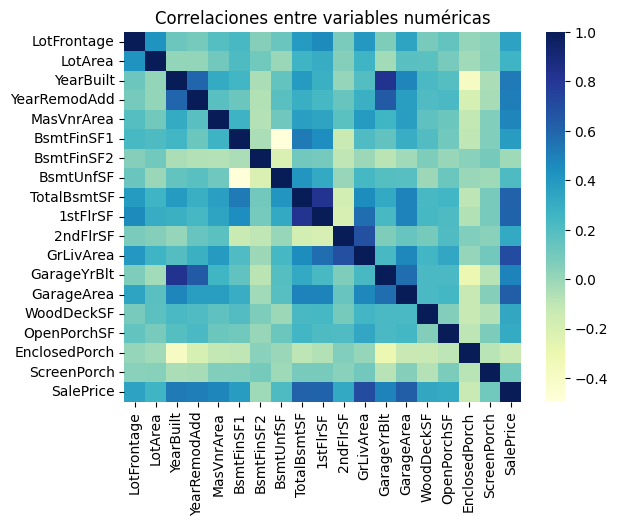

In [ ]:
dataplot = sns.heatmap(num_data.corr(), cmap="YlGnBu").set(title='Correlaciones entre variables numéricas')

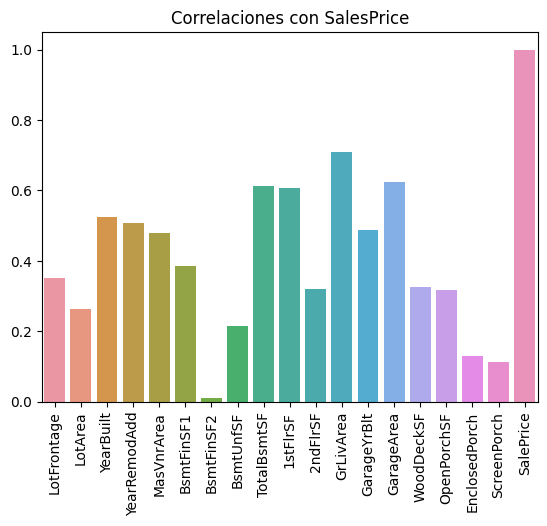

In [ ]:
sns.barplot(x=num_data.corr()["SalePrice"].index,y=[abs(i) for i in list(num_data.corr()["SalePrice"])]).set(title='Correlaciones con SalesPrice')
plt.xticks(rotation=90)
plt.show()

Tomando en cuenta las correlaciones, las variables que podríamos utilizar para realizar el suavizado son YearBuilt, YearRemodAdd, MasVnrArea, TotalBsmtSF, 1stFlrSF, GrLivArea, GarageYrBlt y GarageArea.

/tmp/ipykernel_365/897635609.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


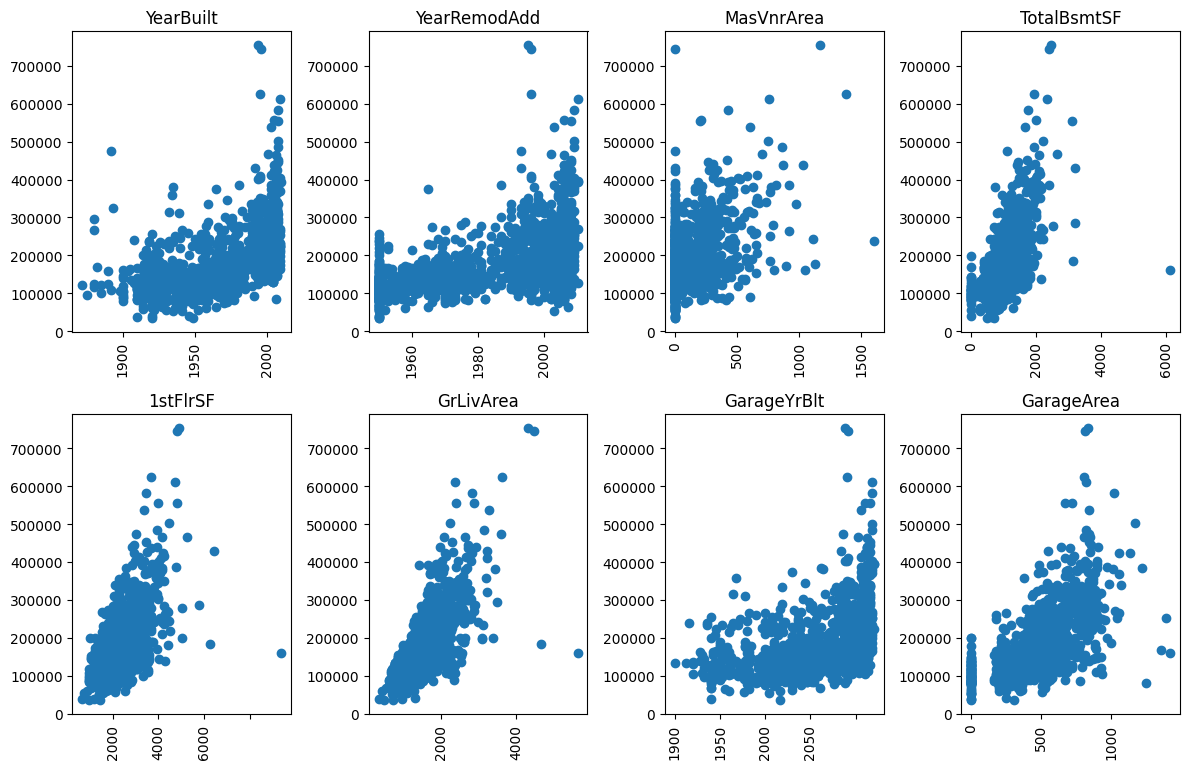

In [ ]:
numerical_cols = 'YearBuilt, YearRemodAdd, MasVnrArea, TotalBsmtSF, 1stFlrSF, GrLivArea, GarageYrBlt, GarageArea'.split(', ')
num_data = num_data[numerical_cols]
num_cols = len(numerical_cols)

num_rows = (num_cols + 1) // 2
num_cols = min(4, num_cols)

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 15))

# Loop through categorical columns and create barplots in the grid
for i, col in enumerate(numerical_cols):
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axes[row_idx][col_idx]

    ax.scatter(x=data[col], y=data["SalePrice"])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_title(col)
    ax.set_ylabel('')
    ax.set_xlabel('')


# If there are empty subplots, remove them
for i in range(len(numerical_cols), num_rows * num_cols):
    fig.delaxes(axes[i // num_cols][i % num_cols])

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
data['MasVnrArea'].value_counts()

0.0      861
108.0      8
72.0       8
180.0      8
16.0       7
        ... 
31.0       1
366.0      1
528.0      1
894.0      1
415.0      1
Name: MasVnrArea, Length: 327, dtype: int64

Observando la forma de los datos, dada la facilidad de ajustar una regresión lineal a las variables 1stFlrSF, GrLivArea y TotalBsmtSF, estas no serán utilizadas para este modelo, por otro lado, la variable MasVnrArea tiene más de la mitad de observaciones en 0, siendo muy sesgada por lo que se descartará también.

In [ ]:
num_data.drop(['1stFlrSF', 'GrLivArea','TotalBsmtSF', 'MasVnrArea'], axis=1, inplace=True)
num_data

,YearBuilt,YearRemodAdd,GarageYrBlt,GarageArea
0,2003,2003,2003.0,548
1,1976,1976,1976.0,460
2,2001,2002,2001.0,608
3,1915,1970,1998.0,642
4,2000,2000,2000.0,836
...,...,...,...,...
1455,1999,2000,1999.0,460
1456,1978,1988,1978.0,500
1457,1941,2006,1941.0,252
1458,1950,1996,1950.0,240


In [ ]:
num_data['SalePrice'] = data['SalePrice']

### Variables categóricas

Para las categóricas, debemos tomar en cuenta aquellas en las que haya una diferencia significativa entre grupos, lo que nos indica que podemos pasar el kernel de tal forma que al tener una nueva observación solo se enfoque en el grupo al que pertenece y así obtener una estimación cercana al valor.

In [ ]:
data.rename(columns={'3SsnPorch': 'SsnPorch'}, inplace=True)
categorical_cols = []
for c in data.columns:
    n_unique = len(data[c].unique())
    if n_unique < 30:
        categorical_cols.append(c)
print(categorical_cols)

['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive', 'SsnPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']


Para determinar qué variables cumplen con esto, observaremos tanto los diagramas de barras de cada variable vs SalePrice y posteriormente validaremos los resultados realizando un ANOVA para cada variable.

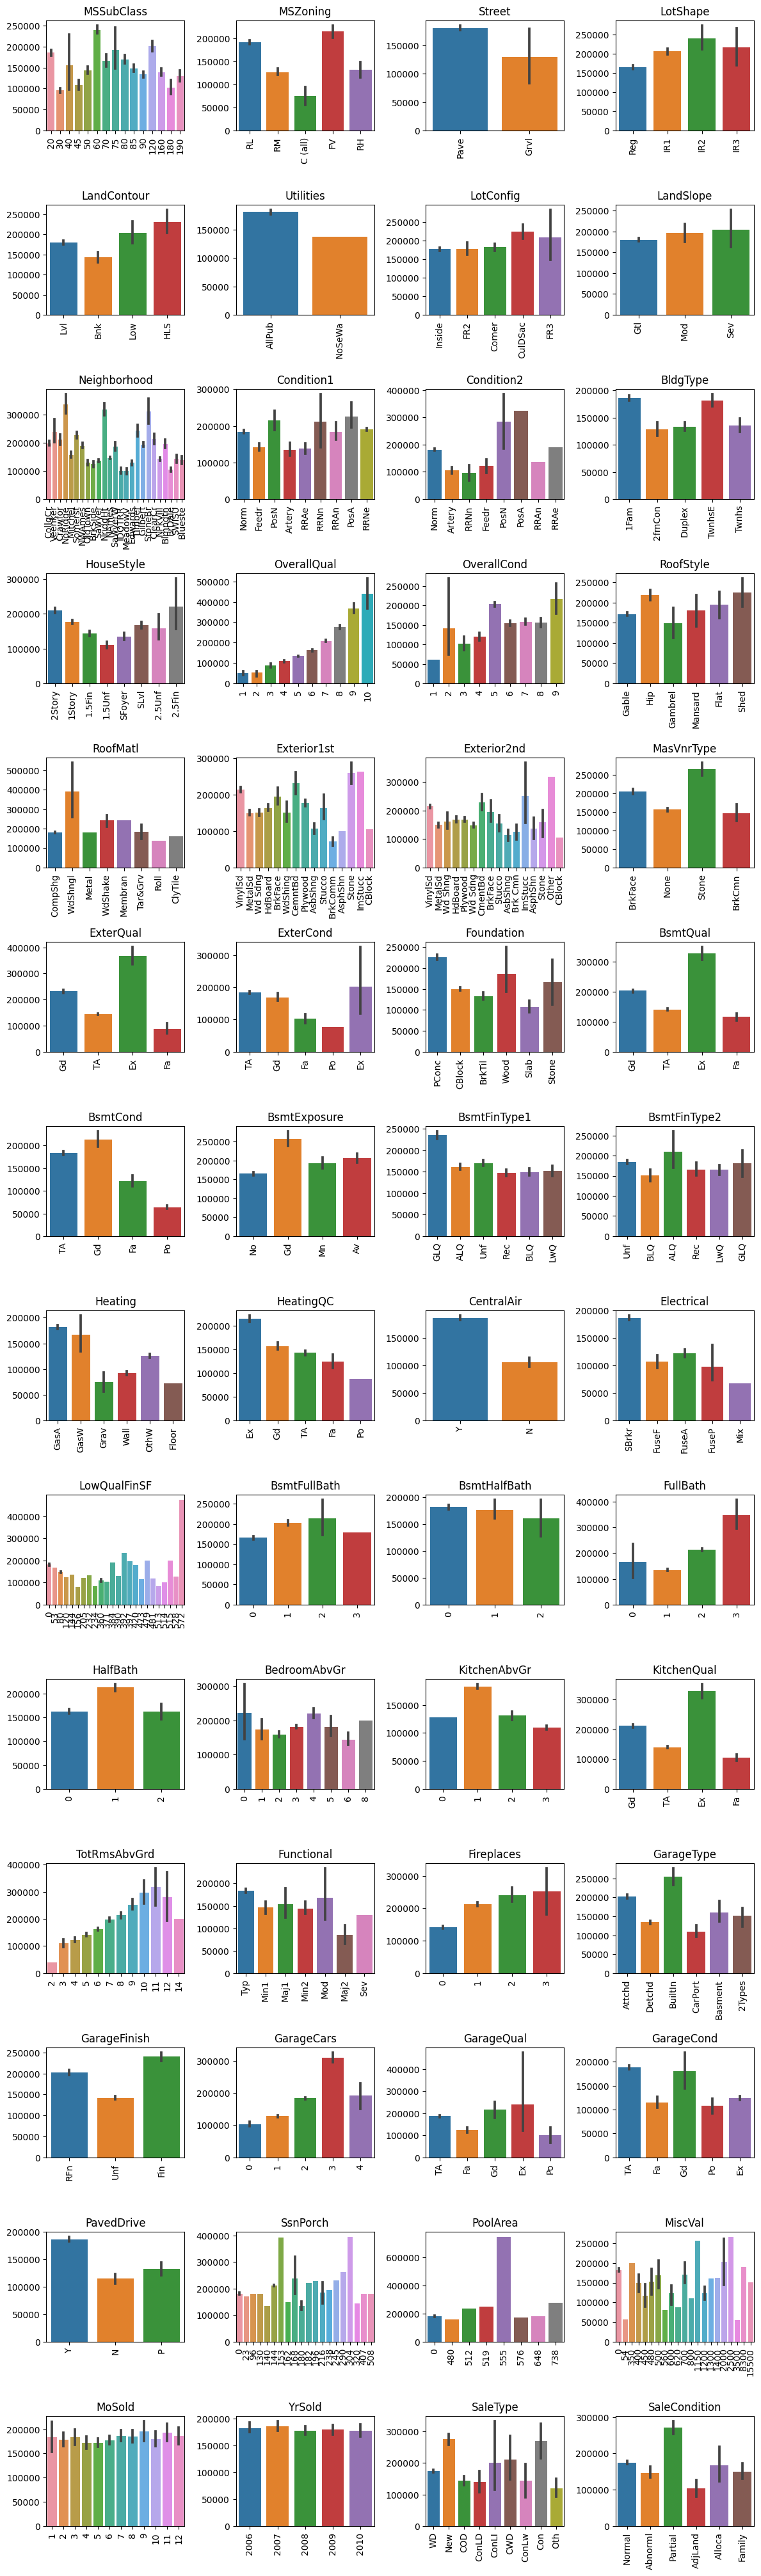

In [ ]:
num_cols = len(categorical_cols)

num_rows = (num_cols + 1) // 2
num_cols = min(4, num_cols)

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 80))

# Loop through categorical columns and create barplots in the grid
for i, col in enumerate(categorical_cols):
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axes[row_idx][col_idx]

    sns.barplot(x=data[col], y=data["SalePrice"], ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_title(col)
    ax.set_ylabel('')
    ax.set_xlabel('')


# If there are empty subplots, remove them
for i in range(len(categorical_cols), num_rows * num_cols):
    fig.delaxes(axes[i // num_cols][i % num_cols])

# Adjust layout
plt.tight_layout()
plt.show()


Viendo los plots, podemos pensar en descartar Street, LandSlope, BsmtFinType1, BsmtFinType2, LowQualFinSF, BsmtHalfBath, SsnPorch, MiscVal y MoSold, por lo que correremos un ANOVA y veremos qué variables pasan el test determinando que todos los grupos son diferentes.

In [ ]:
# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols

anova_cols = []
for var in categorical_cols:
    # Ordinary Least Squares (OLS) model
    model = ols(f'SalePrice ~ C({var})', data=data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    if anova_table['PR(>F)'][0] < 0.01:
        anova_cols.append(var)
print(len(anova_cols))


45


Tras realizar el ANOVA, nos quedamos con 45 posibles variables categóricas a utilizar, entre estas, utilizaremos los gráficos previos, las definiciones y los conteos de los valores para seleccionar variables que no contengan sesgos significativos y que permitan realizar un buen modelo

In [ ]:
cat_data = data[anova_cols].copy()
cat_data

,MSSubClass,MSZoning,LotShape,LandContour,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,...,Fireplaces,GarageType,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,PoolArea,SaleType,SaleCondition
0,60,RL,Reg,Lvl,Inside,CollgCr,Norm,1Fam,2Story,7,...,0,Attchd,RFn,2,TA,TA,Y,0,WD,Normal
1,20,RL,Reg,Lvl,FR2,Veenker,Feedr,1Fam,1Story,6,...,1,Attchd,RFn,2,TA,TA,Y,0,WD,Normal
2,60,RL,IR1,Lvl,Inside,CollgCr,Norm,1Fam,2Story,7,...,1,Attchd,RFn,2,TA,TA,Y,0,WD,Normal
3,70,RL,IR1,Lvl,Corner,Crawfor,Norm,1Fam,2Story,7,...,1,Detchd,Unf,3,TA,TA,Y,0,WD,Abnorml
4,60,RL,IR1,Lvl,FR2,NoRidge,Norm,1Fam,2Story,8,...,1,Attchd,RFn,3,TA,TA,Y,0,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,Reg,Lvl,Inside,Gilbert,Norm,1Fam,2Story,6,...,1,Attchd,RFn,2,TA,TA,Y,0,WD,Normal
1456,20,RL,Reg,Lvl,Inside,NWAmes,Norm,1Fam,1Story,6,...,2,Attchd,Unf,2,TA,TA,Y,0,WD,Normal
1457,70,RL,Reg,Lvl,Inside,Crawfor,Norm,1Fam,2Story,7,...,2,Attchd,RFn,1,TA,TA,Y,0,WD,Normal
1458,20,RL,Reg,Lvl,Inside,NAmes,Norm,1Fam,1Story,5,...,0,Attchd,Unf,1,TA,TA,Y,0,WD,Normal


En primera instancia, eliminaremos las variables que contengan más de 730 observaciones de la misma categoría, lo que es el 50% de las observaciones

In [ ]:
del_col = []
for i in cat_data.columns:
    if any(x >= 730 for x in cat_data[i].value_counts()):
        del_col.append(i)
        print(i)

MSZoning
LotShape
LandContour
LotConfig
Condition1
BldgType
OverallCond
RoofStyle
RoofMatl
MasVnrType
ExterQual
ExterCond
BsmtCond
BsmtExposure
Heating
HeatingQC
CentralAir
Electrical
BsmtFullBath
FullBath
HalfBath
BedroomAbvGr
KitchenAbvGr
KitchenQual
Functional
GarageType
GarageCars
GarageQual
GarageCond
PavedDrive
PoolArea
SaleType
SaleCondition


In [ ]:
cat_data.drop(del_col, axis=1, inplace=True)
cat_data

,MSSubClass,Neighborhood,HouseStyle,OverallQual,Exterior1st,Exterior2nd,Foundation,BsmtQual,BsmtFinType1,TotRmsAbvGrd,Fireplaces,GarageFinish
0,60,CollgCr,2Story,7,VinylSd,VinylSd,PConc,Gd,GLQ,8,0,RFn
1,20,Veenker,1Story,6,MetalSd,MetalSd,CBlock,Gd,ALQ,6,1,RFn
2,60,CollgCr,2Story,7,VinylSd,VinylSd,PConc,Gd,GLQ,6,1,RFn
3,70,Crawfor,2Story,7,Wd Sdng,Wd Shng,BrkTil,TA,ALQ,7,1,Unf
4,60,NoRidge,2Story,8,VinylSd,VinylSd,PConc,Gd,GLQ,9,1,RFn
...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,Gilbert,2Story,6,VinylSd,VinylSd,PConc,Gd,Unf,7,1,RFn
1456,20,NWAmes,1Story,6,Plywood,Plywood,CBlock,Gd,ALQ,7,2,Unf
1457,70,Crawfor,2Story,7,CemntBd,CmentBd,Stone,TA,GLQ,9,2,RFn
1458,20,NAmes,1Story,5,MetalSd,MetalSd,CBlock,TA,GLQ,5,0,Unf


In [ ]:
cat_data.shape

(1460, 12)

Al realizar este primer filtro, nos quedamos con 12 posibles variables categóricas con las cuales trabajar

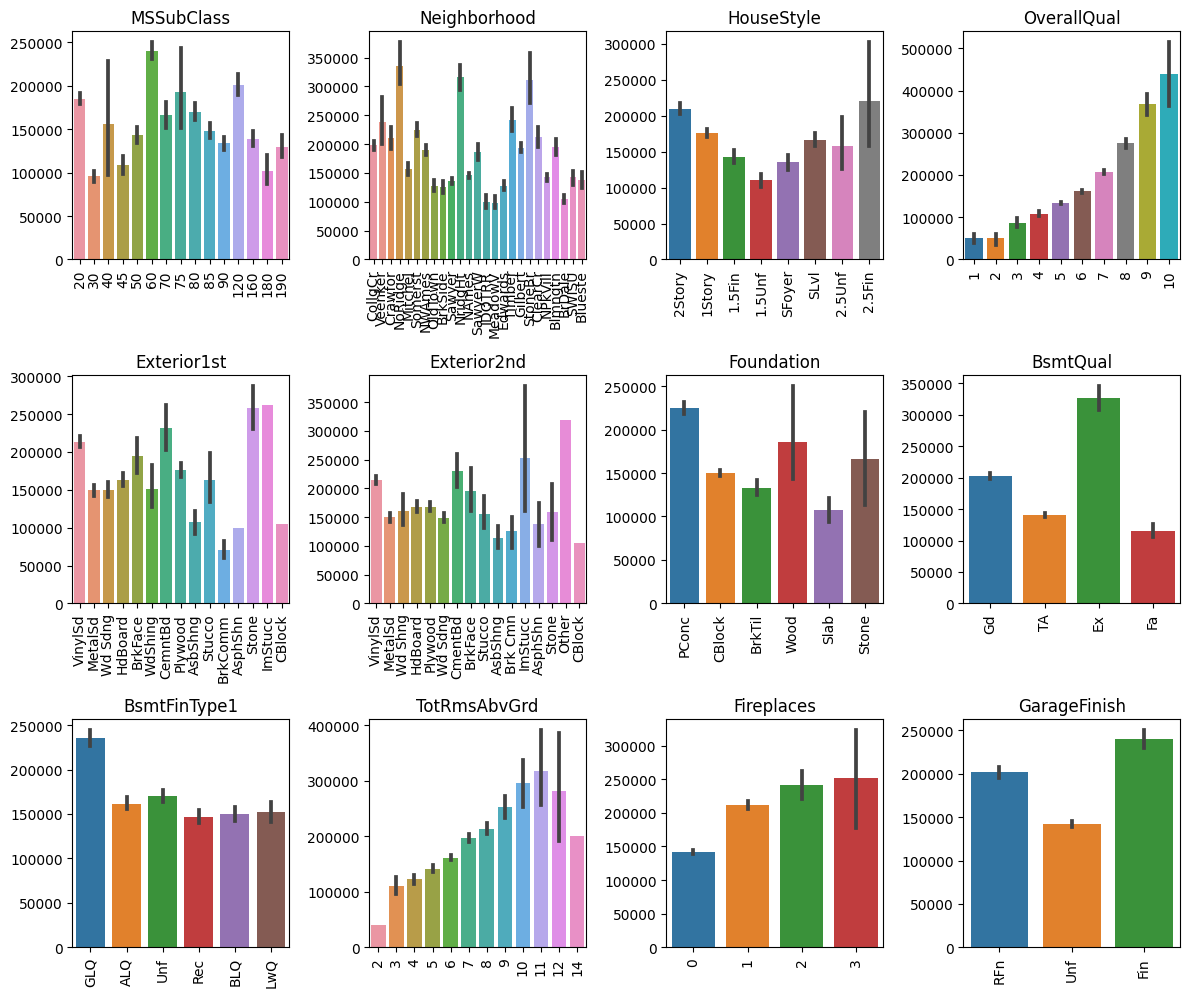

In [ ]:
num_cols = len(cat_data.columns)

num_rows = (num_cols + 1) // 2
num_cols = min(4, num_cols)

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 20))

# Loop through categorical columns and create barplots in the grid
for i, col in enumerate(cat_data.columns):
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axes[row_idx][col_idx]

    sns.barplot(x=cat_data[col], y=data["SalePrice"], ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_title(col)
    ax.set_ylabel('')
    ax.set_xlabel('')


# If there are empty subplots, remove them
for i in range(len(cat_data.columns), num_rows * num_cols):
    fig.delaxes(axes[i // num_cols][i % num_cols])

# Adjust layout
plt.tight_layout()
plt.show()

Viendo las gráficas, a pesar de que el ANOVA descartó varias variables que tenían una media similar en algún par de grupos, podemos observar que BsmtFinType1 tiene grupos con medias similares respecto al precio de venta, por lo cual la descartaremos.

In [ ]:
cat_data.drop(['BsmtFinType1'], axis=1, inplace=True)
cat_data

,MSSubClass,Neighborhood,HouseStyle,OverallQual,Exterior1st,Exterior2nd,Foundation,BsmtQual,TotRmsAbvGrd,Fireplaces,GarageFinish
0,60,CollgCr,2Story,7,VinylSd,VinylSd,PConc,Gd,8,0,RFn
1,20,Veenker,1Story,6,MetalSd,MetalSd,CBlock,Gd,6,1,RFn
2,60,CollgCr,2Story,7,VinylSd,VinylSd,PConc,Gd,6,1,RFn
3,70,Crawfor,2Story,7,Wd Sdng,Wd Shng,BrkTil,TA,7,1,Unf
4,60,NoRidge,2Story,8,VinylSd,VinylSd,PConc,Gd,9,1,RFn
...,...,...,...,...,...,...,...,...,...,...,...
1455,60,Gilbert,2Story,6,VinylSd,VinylSd,PConc,Gd,7,1,RFn
1456,20,NWAmes,1Story,6,Plywood,Plywood,CBlock,Gd,7,2,Unf
1457,70,Crawfor,2Story,7,CemntBd,CmentBd,Stone,TA,9,2,RFn
1458,20,NAmes,1Story,5,MetalSd,MetalSd,CBlock,TA,5,0,Unf


Finalmente, viendo la definición de las variables, Exterior2nd solo aplica cuando el exterior tiene más de un material, al observar los datos, podemos ver que en los casos en los que no aplica, esta variable simplemente toma el valor de Exterior1st, por lo que veremos en cúantos casos no aplica

In [ ]:
len(cat_data.loc[cat_data['Exterior1st'] != cat_data['Exterior2nd']])

215

Dado que esto solo aplica en 215 observaciones, podemos concluir que esta variable está en su mayoría determinada por Exterior1st y por ende la eliminaremos.

In [ ]:
cat_data.drop(['Exterior2nd'], axis=1, inplace=True)
cat_data

,MSSubClass,Neighborhood,HouseStyle,OverallQual,Exterior1st,Foundation,BsmtQual,TotRmsAbvGrd,Fireplaces,GarageFinish
0,60,CollgCr,2Story,7,VinylSd,PConc,Gd,8,0,RFn
1,20,Veenker,1Story,6,MetalSd,CBlock,Gd,6,1,RFn
2,60,CollgCr,2Story,7,VinylSd,PConc,Gd,6,1,RFn
3,70,Crawfor,2Story,7,Wd Sdng,BrkTil,TA,7,1,Unf
4,60,NoRidge,2Story,8,VinylSd,PConc,Gd,9,1,RFn
...,...,...,...,...,...,...,...,...,...,...
1455,60,Gilbert,2Story,6,VinylSd,PConc,Gd,7,1,RFn
1456,20,NWAmes,1Story,6,Plywood,CBlock,Gd,7,2,Unf
1457,70,Crawfor,2Story,7,CemntBd,Stone,TA,9,2,RFn
1458,20,NAmes,1Story,5,MetalSd,CBlock,TA,5,0,Unf


### Posibles variables a considerar

Tras realizar los filtros necesarios, nos quedamos con 14 posibles variables, las cuales son:

In [ ]:
data = pd.concat([cat_data, num_data], axis=1)
data

,MSSubClass,Neighborhood,HouseStyle,OverallQual,Exterior1st,Foundation,BsmtQual,TotRmsAbvGrd,Fireplaces,GarageFinish,YearBuilt,YearRemodAdd,GarageYrBlt,GarageArea,SalePrice
0,60,CollgCr,2Story,7,VinylSd,PConc,Gd,8,0,RFn,2003,2003,2003.0,548,208500
1,20,Veenker,1Story,6,MetalSd,CBlock,Gd,6,1,RFn,1976,1976,1976.0,460,181500
2,60,CollgCr,2Story,7,VinylSd,PConc,Gd,6,1,RFn,2001,2002,2001.0,608,223500
3,70,Crawfor,2Story,7,Wd Sdng,BrkTil,TA,7,1,Unf,1915,1970,1998.0,642,140000
4,60,NoRidge,2Story,8,VinylSd,PConc,Gd,9,1,RFn,2000,2000,2000.0,836,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,Gilbert,2Story,6,VinylSd,PConc,Gd,7,1,RFn,1999,2000,1999.0,460,175000
1456,20,NWAmes,1Story,6,Plywood,CBlock,Gd,7,2,Unf,1978,1988,1978.0,500,210000
1457,70,Crawfor,2Story,7,CemntBd,Stone,TA,9,2,RFn,1941,2006,1941.0,252,266500
1458,20,NAmes,1Story,5,MetalSd,CBlock,TA,5,0,Unf,1950,1996,1950.0,240,142125


## Implementación de suavizado con kernel

### Funciones de kernel

In [ ]:
# Creamos una funcion para K-nearest neighbors
def knn(k: int, point:float,data_x:np.ndarray,data_y:np.ndarray) -> float:
    idx_sorted = np.argsort((data_x-point)*(data_x-point))[:k]
    return data_y[idx_sorted].mean()

# Creamos una funcion para Epanechnikov
def Epanechnikov(lmbda:float, point:float,
                 data_x:np.ndarray, data_y:np.ndarray) -> float:
    t = np.absolute(data_x-point)/lmbda
    k = np.where(t <= 1, .75*(1-t), 0)
    return (k @ data_y).sum()/k.sum()


# Creamos una funcion para K-nearest neighbors con variables variables
def knn_mv(k: int, point:np.array,
        data_x:np.ndarray, data_y:np.ndarray) -> float:
    sq_dis = (data_x-point)*(data_x-point)

    #Hacemos la suma de las distancias al cuadrado para cada row
    t = 0
    sq_dis_sum = []
    for r in sq_dis:
      for v in r:
        t+=v
      sq_dis_sum.append(t)
      t=0
    sq_dis_sum = np.array(sq_dis_sum)
    #En principio podriamos sacarle sqrt, pero se puede omitir en este caso
    # pues solo usamos ese valor para orderar. En la funcion vista en clase tampoco se saca.
    idx_sorted = np.argsort(sq_dis_sum)[:k]
    return data_y[idx_sorted].mean()


# Creamos una funcion para Epanechnikov para varias variables
def Epanechnikov_mv(lmbda:float, point:np.array,
                 data_x:np.ndarray, data_y:np.ndarray) -> float:
    t = np.absolute(data_x-point)/lmbda

    k = np.where(t <= 1, .75*(1-t), 0)

    #Hacemos la suma de las distancias para cada row
    t = 0
    dis_sum = []
    for r in k:
        for v in r:
            t+=v
        dis_sum.append(t)
        t=0
    dis_sum = np.array(dis_sum)
    return (dis_sum @ data_y).sum()/dis_sum.sum()

## Modelos

Para este ejercicio, utilizaremos varios modelos, uno que tome todas las variables numéricas, otro que considere todas las numéricas con todas las categóricas y posteriormente eliminaremos algunas variables intentando mejorar estos modelos iniciales.

### Modelo con todas las numéricas

In [ ]:
X = num_data.drop(columns=['SalePrice'])
X = X.select_dtypes(include='number')
y = data['SalePrice']

In [ ]:
X.head()

,YearBuilt,YearRemodAdd,GarageYrBlt,GarageArea
0,2003,2003,2003.0,548
1,1976,1976,1976.0,460
2,2001,2002,2001.0,608
3,1915,1970,1998.0,642
4,2000,2000,2000.0,836


En primera instancia, escalaremos los datos

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

Y tomaremos el 90% de los datos para hacer un entrenamiento con validación cruzada buscando el mejor kernel y el mejor número de vecinos o lambda que minimice el error cuadrático medio en las predicciones. Esta validación cruzada la realizaremos con 50 iteraciones tomando valores al azar tomando la medida de error cuadrático medio

In [ ]:
y = np.array(y)
X, X_test, y, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

En primera instancia, probaremos con el kernel knn_mv implementado para varias variables

In [ ]:
knn_mse = {}
for k in range(2,10,1):
    print(f'Evaluando {k} vecinos')
    for i in range(50):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)
        #xgrid = np.linspace(X.min(axis=0), X.max(axis=0)-1, 10001)
        y_knn = np.array([knn_mv(k, x, X, y) for x in X_val])

        rmse_val = np.sqrt(mean_squared_error(y_val, y_knn))
        if i == 0:
            knn_mse[k] = [rmse_val]
        else:
            knn_mse[k].append(rmse_val)
for i in knn_mse.keys():
    print(f'Para {i} vecinos se tiene en promedio {np.mean(knn_mse[i])} rmse y una varianza de {np.var(knn_mse[i])}')

Evaluando 2 vecinos
Evaluando 3 vecinos
Evaluando 4 vecinos
Evaluando 5 vecinos
Evaluando 6 vecinos
Evaluando 7 vecinos
Evaluando 8 vecinos
Evaluando 9 vecinos
Para 2 vecinos se tiene en promedio 50047.81594227422 rmse y una varianza de 7145355.199799576
Para 3 vecinos se tiene en promedio 48228.00504582156 rmse y una varianza de 6058566.094650814
Para 4 vecinos se tiene en promedio 50299.47701502609 rmse y una varianza de 7280141.825173616
Para 5 vecinos se tiene en promedio 50306.77736540583 rmse y una varianza de 6109823.38764373
Para 6 vecinos se tiene en promedio 49230.94276050712 rmse y una varianza de 5806856.395087991
Para 7 vecinos se tiene en promedio 50604.618036036954 rmse y una varianza de 6900950.709747931
Para 8 vecinos se tiene en promedio 50339.48295877781 rmse y una varianza de 7583627.16322143
Para 9 vecinos se tiene en promedio 52270.94475602291 rmse y una varianza de 9142296.734474678


Para el caso de un kernel KNN con variables numéricas, el número de vecinos que logra minimizar el error cuadrático medio bajo y mantener un número bajo en la varianza a comparación del resto es 3

In [ ]:
epa_mse = {}
for lmbda in np.linspace(0.1,0.3,20):
    print(f'revisando para lambda {lmbda}')
    for i in range(50):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)
        y_epa = np.array([Epanechnikov_mv(lmbda, x, X, y) for x in X_val])
        mse_val = np.sqrt(mean_squared_error(y_val, y_epa))
        if i == 0:
            epa_mse[lmbda] = [mse_val]
        else:
            epa_mse[lmbda].append(mse_val)
for i in epa_mse.keys():
    print(f'Para un lambda de {i} se tiene en promedio {np.mean(epa_mse[i])} rmse y una varianza de {np.var(epa_mse[i])}')

revisando para lambda 0.1
revisando para lambda 0.1105263157894737
revisando para lambda 0.12105263157894737
revisando para lambda 0.13157894736842107
revisando para lambda 0.14210526315789473
revisando para lambda 0.15263157894736842
revisando para lambda 0.1631578947368421
revisando para lambda 0.17368421052631577
revisando para lambda 0.1842105263157895
revisando para lambda 0.19473684210526315
revisando para lambda 0.20526315789473684
revisando para lambda 0.21578947368421053
revisando para lambda 0.22631578947368422
revisando para lambda 0.2368421052631579
revisando para lambda 0.24736842105263157
revisando para lambda 0.2578947368421053
revisando para lambda 0.26842105263157895
revisando para lambda 0.2789473684210526
revisando para lambda 0.2894736842105263
revisando para lambda 0.3
Para un lambda de 0.1 se tiene en promedio 58115.86460784759 rmse y una varianza de 15992937.613607468
Para un lambda de 0.1105263157894737 se tiene en promedio 58719.23352354 rmse y una varianza de 

En este caso, al incluir únicamente las variables numéricas usando el kernel de Epanechnikov tiene un desempeño notablemente inferior al kernel KNN en cuanto al error cuadrático medio tanto en media como en varianza.

## Kernel con todas las variables

### Preprocessing variables categóricas

In [ ]:
X_num = num_data.drop(['SalePrice'], axis=1) #Numerica
X_cat = cat_data #categorica ordinal, cat no ordinal respectivamente.
y = data['SalePrice']

Utilizamos One Hot Encoder para las variables categóricas. Posteriormente agregaremos estan columnas a X

In [ ]:
enc = OneHotEncoder(drop='first').fit(X_cat) #drop first porque no necesitamos una columna extra
# para la primera, solo poner en 0 las otras. Podriamos no dropearlo para interpretar más facil el df encoded
X_cat_enc = enc.transform(X_cat).toarray()
enc.categories_

[array([ 20,  30,  40,  45,  50,  60,  70,  75,  80,  85,  90, 120, 160,
        180, 190]),
 array(['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr',
        'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel',
        'NAmes', 'NPkVill', 'NWAmes', 'NoRidge', 'NridgHt', 'OldTown',
        'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber',
        'Veenker'], dtype=object),
 array(['1.5Fin', '1.5Unf', '1Story', '2.5Fin', '2.5Unf', '2Story',
        'SFoyer', 'SLvl'], dtype=object),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array(['AsbShng', 'AsphShn', 'BrkComm', 'BrkFace', 'CBlock', 'CemntBd',
        'HdBoard', 'ImStucc', 'MetalSd', 'Plywood', 'Stone', 'Stucco',
        'VinylSd', 'Wd Sdng', 'WdShing'], dtype=object),
 array(['BrkTil', 'CBlock', 'PConc', 'Slab', 'Stone', 'Wood'], dtype=object),
 array(['Ex', 'Fa', 'Gd', 'TA', nan], dtype=object),
 array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14]),
 array([0, 1, 2, 3]),
 array(['Fin'

In [ ]:
df_cat_enc = pd.DataFrame(X_cat_enc, columns=enc.get_feature_names_out([c for c in X_cat.columns]))
df_cat_enc

,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,...,TotRmsAbvGrd_10,TotRmsAbvGrd_11,TotRmsAbvGrd_12,TotRmsAbvGrd_14,Fireplaces_1,Fireplaces_2,Fireplaces_3,GarageFinish_RFn,GarageFinish_Unf,GarageFinish_nan
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1457,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1458,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
X = pd.concat([X_num,df_cat_enc], axis=1)
X

,YearBuilt,YearRemodAdd,GarageYrBlt,GarageArea,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,...,TotRmsAbvGrd_10,TotRmsAbvGrd_11,TotRmsAbvGrd_12,TotRmsAbvGrd_14,Fireplaces_1,Fireplaces_2,Fireplaces_3,GarageFinish_RFn,GarageFinish_Unf,GarageFinish_nan
0,2003,2003,2003.0,548,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1976,1976,1976.0,460,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,2001,2002,2001.0,608,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1915,1970,1998.0,642,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,2000,2000,2000.0,836,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1999,2000,1999.0,460,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1456,1978,1988,1978.0,500,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1457,1941,2006,1941.0,252,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1458,1950,1996,1950.0,240,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
y = np.array(y)

X, X_test, y, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


In [ ]:
y

array([250000, 187100, 133900, ..., 115000, 189950, 174000])

In [ ]:
knn_mse = {}
for k in range(2,10,1):
    print(k)
    for i in range(50):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)
        #xgrid = np.linspace(X.min(axis=0), X.max(axis=0)-1, 10001)
        y_knn = np.array([knn_mv(k, x, X, y) for x in X_val])

        rmse_val = np.sqrt(mean_squared_error(y_val, y_knn))
        if i == 0:
            knn_mse[k] = [rmse_val]
        else:
            knn_mse[k].append(rmse_val)
for i in knn_mse.keys():
    print(f'Para {i} vecinos se tiene en promedio {np.mean(knn_mse[i])} rmse y una varianza de {np.var(knn_mse[i])}')

2
3
4
5
6
7
8
9
Para 2 vecinos se tiene en promedio 45374.107353748244 rmse y una varianza de 10682554.41422572
Para 3 vecinos se tiene en promedio 38767.96062339642 rmse y una varianza de 5310865.318469281
Para 4 vecinos se tiene en promedio 41701.52350047824 rmse y una varianza de 5346618.275830573
Para 5 vecinos se tiene en promedio 40069.5611137879 rmse y una varianza de 4281543.181072456
Para 6 vecinos se tiene en promedio 39373.083877895726 rmse y una varianza de 4418733.09779387
Para 7 vecinos se tiene en promedio 40799.7134761377 rmse y una varianza de 5979733.647199746
Para 8 vecinos se tiene en promedio 40368.961903759155 rmse y una varianza de 5872972.71684608
Para 9 vecinos se tiene en promedio 41197.876748396324 rmse y una varianza de 6651400.015227424


En este caso se podria escoger 3 vecinos debido a un menor RMSE promedio, sin embargo el caso de 6 vecinos presenta un promedio similar con menor varianza.

In [ ]:
epa_mse = {}
for lmbda in np.linspace(0.1,0.3,20):
    print(lmbda)
    for i in range(50):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)
        y_epa = np.array([Epanechnikov_mv(lmbda, x, X, y) for x in X_val])
        mse_val = np.sqrt(mean_squared_error(y_val, y_epa))
        if i == 0:
            epa_mse[lmbda] = [mse_val]
        else:
            epa_mse[lmbda].append(mse_val)
for i in epa_mse.keys():
    print(f'Para un lambda de {i} se tiene en promedio {np.mean(epa_mse[i])} rmse y una varianza de {np.var(epa_mse[i])}')

0.1
0.1105263157894737
0.12105263157894737
0.13157894736842107
0.14210526315789473
0.15263157894736842
0.1631578947368421
0.17368421052631577
0.1842105263157895
0.19473684210526315
0.20526315789473684
0.21578947368421053
0.22631578947368422
0.2368421052631579
0.24736842105263157
0.2578947368421053
0.26842105263157895
0.2789473684210526
0.2894736842105263
0.3
Para un lambda de 0.1 se tiene en promedio 77095.14510868823 rmse y una varianza de 18392522.401386634
Para un lambda de 0.1105263157894737 se tiene en promedio 76799.81831496031 rmse y una varianza de 16083864.787650552
Para un lambda de 0.12105263157894737 se tiene en promedio 77291.38266379607 rmse y una varianza de 15482950.961883714
Para un lambda de 0.13157894736842107 se tiene en promedio 76816.77058090689 rmse y una varianza de 17254598.71041535
Para un lambda de 0.14210526315789473 se tiene en promedio 76038.5588550837 rmse y una varianza de 19755075.1698173
Para un lambda de 0.15263157894736842 se tiene en promedio 75587.

Al igual que el caso anterior se tiene un peor rendimiento por parte de Epanechnikov

## Modelo limitando variables

Sentimos que el incluir variables numéricas es clave para el correcto funcionamiento del kernel, por lo tanto realizaremos un modelo que incluya todas las variables, además de estas incluiremos la variable OverallQual que parece segregar bastante bien los datos en varios grupos con medias muy diferentes

In [ ]:
X_num = num_data.drop(['SalePrice'], axis=1) #Numerica
X_cat = data[['OverallQual','Neighborhood']] #categorica ordinal, cat no ordinal respectivamente.
y = data['SalePrice']
enc = OneHotEncoder(drop='first').fit(X_cat) #drop first porque no necesitamos una columna extra
# para la primera, solo poner en 0 las otras. Podriamos no dropearlo para integretar más facil el df encoded
X_cat_enc = enc.transform(X_cat).toarray()
df_cat_enc = pd.DataFrame(X_cat_enc, columns=enc.get_feature_names_out([c for c in X_cat.columns]))
X = pd.concat([X_num,df_cat_enc], axis=1)
X

,YearBuilt,YearRemodAdd,GarageYrBlt,GarageArea,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,...,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
0,2003,2003,2003.0,548,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1976,1976,1976.0,460,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2001,2002,2001.0,608,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1915,1970,1998.0,642,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2000,2000,2000.0,836,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1999,2000,1999.0,460,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1456,1978,1988,1978.0,500,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1457,1941,2006,1941.0,252,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1458,1950,1996,1950.0,240,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = np.array(y)

X, X_test, y, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

Veamos el resultado con KNN

In [ ]:
knn_mse = {}
for k in range(2,10,1):
    print(k)
    for i in range(50):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)
        #xgrid = np.linspace(X.min(axis=0), X.max(axis=0)-1, 10001)
        y_knn = np.array([knn_mv(k, x, X, y) for x in X_val])

        rmse_val = np.sqrt(mean_squared_error(y_val, y_knn))
        if i == 0:
            knn_mse[k] = [rmse_val]
        else:
            knn_mse[k].append(rmse_val)
for i in knn_mse.keys():
    print(f'Para {i} vecinos se tiene en promedio {np.mean(knn_mse[i])} mse y una varianza de {np.var(knn_mse[i])}')

2
3
4
5
6
7
8
9
Para 2 vecinos se tiene en promedio 44253.89024026249 mse y una varianza de 10866775.176003082
Para 3 vecinos se tiene en promedio 38605.42563256053 mse y una varianza de 4276978.364208286
Para 4 vecinos se tiene en promedio 41192.21658939417 mse y una varianza de 4631984.066990028
Para 5 vecinos se tiene en promedio 39080.696472400494 mse y una varianza de 5311973.573430101
Para 6 vecinos se tiene en promedio 38157.550553014764 mse y una varianza de 5147561.442898934
Para 7 vecinos se tiene en promedio 39420.394321421765 mse y una varianza de 3755965.5023690546
Para 8 vecinos se tiene en promedio 39793.57468935097 mse y una varianza de 5481157.438461844
Para 9 vecinos se tiene en promedio 41233.27805456297 mse y una varianza de 5263248.493673849


Este caso presenta un resultado importante donde los 3 y 6 vecinos llegan a tener un bajo RMSE promedio con una varianza comparable los previamente considerados como mejores

Para Epanechnikov

In [ ]:
epa_mse = {}
for lmbda in np.linspace(0.1,0.3,20):
    print(lmbda)
    for i in range(30):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)
        y_epa = np.array([Epanechnikov_mv(lmbda, x, X, y) for x in X_val])
        mse_val = np.sqrt(mean_squared_error(y_val, y_epa))
        if i == 0:
            epa_mse[lmbda] = [mse_val]
        else:
            epa_mse[lmbda].append(mse_val)
for i in epa_mse.keys():
    print(f'Para un lambda de {i} se tiene en promedio {np.mean(epa_mse[i])} mse y una varianza de {np.var(epa_mse[i])}')

0.1
0.1105263157894737
0.12105263157894737
0.13157894736842107
0.14210526315789473
0.15263157894736842
0.1631578947368421
0.17368421052631577
0.1842105263157895
0.19473684210526315
0.20526315789473684
0.21578947368421053
0.22631578947368422
0.2368421052631579
0.24736842105263157
0.2578947368421053
0.26842105263157895
0.2789473684210526
0.2894736842105263
0.3
Para un lambda de 0.1 se tiene en promedio 75433.11381811714 mse y una varianza de 17700273.31775478
Para un lambda de 0.1105263157894737 se tiene en promedio 76512.99815018119 mse y una varianza de 21341472.322005775
Para un lambda de 0.12105263157894737 se tiene en promedio 77018.65305092392 mse y una varianza de 9290742.68302793
Para un lambda de 0.13157894736842107 se tiene en promedio 75340.88453164432 mse y una varianza de 16896254.991187986
Para un lambda de 0.14210526315789473 se tiene en promedio 75564.15660966568 mse y una varianza de 18965771.618880622
Para un lambda de 0.15263157894736842 se tiene en promedio 76428.8306

Similarmente el metodo de KNN sigue teniendo un rendimiento fuertemente superior para este caso. Es importante considerar que aunque este sea un mejor modo, ser podria encontrar algo mejor con una busqueda mas amplia sobre las diferentes variables y ajustando a pesos al estilo de los metodos de regularizacion.

## Evaluación con los datos independientes

En este caso, concluimos que el mejor modelo a utilizar para Kernel es el de KNN con 6 vecinos sobre las variables numéricas YearBuilt, YearRemodAdd, GarageYrBlt y GarageArea y con las categóricas OverallQual y Neighborhood. A continuación haremos la prueba con los datos del conjunto de test.

49345.506667706


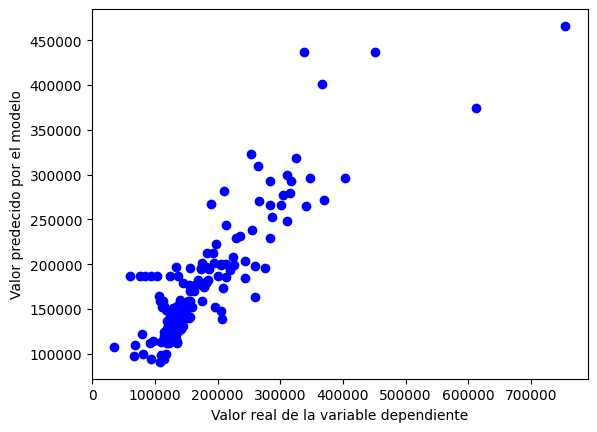

In [ ]:
k=6
y_knn_test_pred = np.array([knn_mv(k, x, X, y) for x in X_test])

rmse = np.sqrt(mean_squared_error(y_test, y_knn_test_pred))
plt.scatter(y_test, y_knn_test_pred, color="blue")
plt.xlabel('Valor real de la variable dependiente')
plt.ylabel('Valor predecido por el modelo')
print(rmse)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=06f5c9d6-1002-41eb-bf1f-9a276626cf93' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>